In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
from scipy.stats import logistic
import pymc3 as pm
import pymc3.parallel_sampling as ps
import theano
import theano.tensor as tt
import arviz as az
from scipy.integrate import quad
from scipy.stats import norm
import pyjags
import pickle

# Get data for all emotions

In [2]:
# load rating data from pilot study 2
all_data = pd.read_csv("/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_rating_data/rating_data_second_part_anxiety.csv")

In [3]:
all_data.head()

In [4]:
print(len(all_data))

## Choose one emotion

In [2]:
emotion = "anxiety"
main_path_rating_data = "/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_rating_data/"

rating_data_first_part = pd.read_csv(main_path_rating_data + "rating_data_first_part_" + emotion + ".csv")
rating_data_second_part = pd.read_csv(main_path_rating_data + "rating_data_second_part_" + emotion + ".csv")

# Combine the data
rating_data_combined = pd.concat([rating_data_first_part, rating_data_second_part])

# so let's start by testing out anxiety for example
rating_data_emo = rating_data_combined[rating_data_combined["emotionName"] == emotion].copy()

In [3]:
print(len(rating_data_emo))
emotion_focus = "anxiety"
all_data_emo = rating_data_emo[rating_data_emo["emotionName"] == emotion_focus].copy()

In [4]:
# so let's start by testing out anxiety for example
emotion_focus = "anxiety"
all_data_emo = all_data_emo[all_data_emo["emotionName"] == emotion_focus].copy()

In [5]:
print(len(all_data_emo))

In [42]:
rating_data_emo.head()

,rating_phase1,videoID,emotionName,rating_phase2,average_rating,variance_rating,subject_id
0,6.08,2119,sadness,7.00,6.540,0.650538,F9hEyhHx2UcDoYq9p4H28cHBXRa2
1,2.99,1703,sadness,3.95,3.470,0.678823,F9hEyhHx2UcDoYq9p4H28cHBXRa2
2,3.00,746,sadness,4.99,3.995,1.407142,F9hEyhHx2UcDoYq9p4H28cHBXRa2
3,5.05,490,sadness,5.74,5.395,0.487904,F9hEyhHx2UcDoYq9p4H28cHBXRa2
4,7.00,2035,sadness,7.00,7.000,0.000000,F9hEyhHx2UcDoYq9p4H28cHBXRa2


# Load data and for all emotions separated between long and short

In [4]:
main_path_rating_data = "/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_rating_data/"

rating_data_long_duration = pd.read_csv(main_path_rating_data + "rating_data_complete_long_duration_all_emotions.csv")
rating_data_short_duration = pd.read_csv(main_path_rating_data + "rating_data_complete_short_duration_all_emotions.csv")

In [ ]:
print(rating)

# Load data for short and long all emotions

In [6]:
# load rating data from pilot study 2
all_data_long = pd.read_csv("/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_rating_data/rating_data_complete_long_duration_all_emotions.csv")
all_data_short = pd.read_csv("/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_rating_data/rating_data_complete_short_duration_all_emotions.csv")

In [7]:
all_data_long.head()

,videoID,emotionName,durationBlackScreen,rating,average_rating,variance_rating,subject_id
0,1174,disgust,2600,NaN,4.59,NaN,O4mOO2W80Od34gyNg7l6hJzqlDm2
1,1485,sadness,2600,6.37,5.81,0.791960,O4mOO2W80Od34gyNg7l6hJzqlDm2
2,829,disgust,2600,2.96,2.92,0.056569,O4mOO2W80Od34gyNg7l6hJzqlDm2
3,746,sadness,2600,3.93,4.41,0.678823,O4mOO2W80Od34gyNg7l6hJzqlDm2
4,490,sadness,2600,5.70,5.35,0.494975,O4mOO2W80Od34gyNg7l6hJzqlDm2


In [10]:
all_data_emo = all_data_long

# Define functions for bayesian model

In [9]:
def f(v, mu, s):
    return 0.5 * (1 + np.tanh((v - mu) / (2 * s)))

def f_theano(v,mu,s):
    return 0.5 * (1 + tt.tanh((v - mu) / (2 * s)))

def f_inv(v_tilde, mu, s):
    v_tilde = np.clip(v_tilde, 1e-8, 1 - 1e-8) # find another way of doing this but basically will always need to clip because extremeties don't work in this model
    result = mu + s * np.log(v_tilde / (1 - v_tilde))
    return result

# so f inv is supposed to be Phi and from the article Φ() is the CDF of the standard normal distribution
# however, in the article they say "F(v) is defined as the cumulative density function (CDF) of the prior distribution p(v)."
# and, Phi is defined as the inverse of F.
# THIS IS CONFUSING!

# The first derivative of the inverse CDF
def phi_prime(v_tilde, s):
    return s / (v_tilde * (1 - v_tilde))

# The second derivative of the inverse CDF
def phi_double_prime(v_tilde, s):
    return s * (2 * v_tilde - 1) / (v_tilde ** 2 * (1 - v_tilde) ** 2)

# Good note on phi prime and phi double prime: 
# These derivatives give you a way to compute the change in 
# perceived values due to small changes in the true values, 
# incorporating internal and external noises.

def f_prime_theano(v, mu, s):
    p = f_theano(v, mu, s)
    return p * (1 - p)

def g(v_hat):
    return 1 / (1 + np.exp(-v_hat))

def g_inv_theano(v):
    return tt.log(v / (1 - v))

def g_inv_prime_theano(v):
    return 1 / (v * (1 - v))

# Define the sech function using theano
def sech(x):
    return 2 / (tt.exp(x) + tt.exp(-x))

# Define the log probability function for the logistic distribution
def logp_logistic(v, mu, s):
    # logistic PDF transformed to log-probability
    return tt.log(sech((v - mu) / (2 * s))**2 / (4 * s))

# Adaptation of functions using theanos, with numpy for visualization of prior distribution
def sech_bis(x):
    return 2 / (np.exp(x) + np.exp(-x))

def logp_logistic_bis(v, mu, s):
    return np.log(sech_bis((v - mu) / (2 * s))**2 / (4 * s))

def normal_cdf(x):
    """ Compute the CDF of the standard normal distribution at x. """
    return 0.5 * (1 + tt.erf(x / tt.sqrt(2)))

The error function (erf) is closely related to the cumulative distribution function (CDF) of the standard normal distribution. The CDF of the standard normal distribution, often represented by Φ(x), can be expressed in terms of the error function.

This relation arises because the error function is defined as the probability excess of a random variable with a normal distribution (mean = 0, standard deviation = 1/sqrt(2)) falling in the range between 0 and x, multiplied by 2. Therefore, to transform this to the standard normal distribution (mean = 0, standard deviation = 1), the input is adjusted by dividing by sqrt(2), and it is scaled to adjust the output range from [0, 1] instead of [-1, 1].

# Fit Bayesian model

In [8]:
# Parameters
delta = 0.05 

In [11]:
all_participants = np.unique(all_data_emo["subject_id"])

In [12]:
print(len(all_participants))

57


In [11]:
# posterior_distributions_all_participants = {}

In [12]:
# posterior_distributions_all_participants_lower_sampling = {}

In [13]:
posterior_distributions_all_participants_higher_sampling = {}

In [14]:
# TODO: modify code such that I save for each participant their behavioral normalized data too

In [14]:
print(len(posterior_distributions_all_participants_higher_sampling))

0


In [15]:
def squeeze_data(data, lower, upper):
    range = upper - lower
    squeezed = lower + range * (1 / (1 + np.exp(-((data - 0.5) * 10))))  # Logistic transformation
    return squeezed

# Clipping function
def clip_data(data, lower, upper):
    return np.clip(data, lower, upper)

0VVMDMpWxwVD3Hivuk2kvCHyQXh2


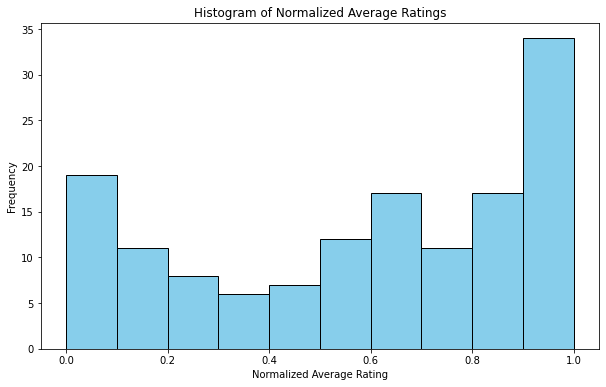

Estimated Prior Mean: 0.582147852112676
Estimated Prior Standard Deviation: 0.3309892180192987


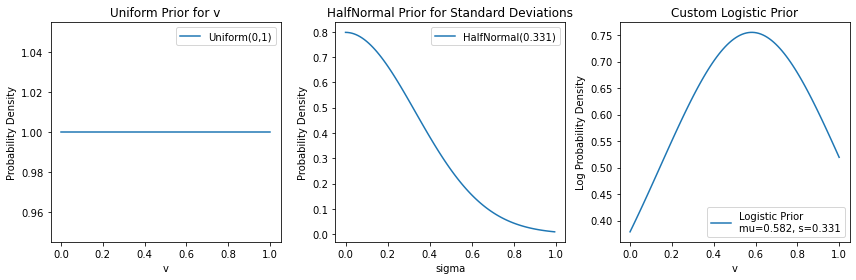

0ejC9wujLDO1ECeFO3U0Zt7Ehq43


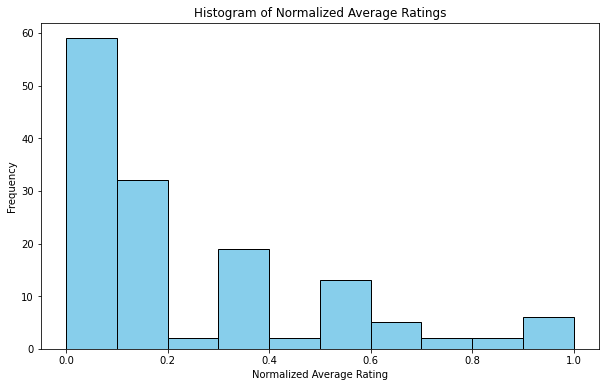

Estimated Prior Mean: 0.23011752582159634
Estimated Prior Standard Deviation: 0.26774533503889086


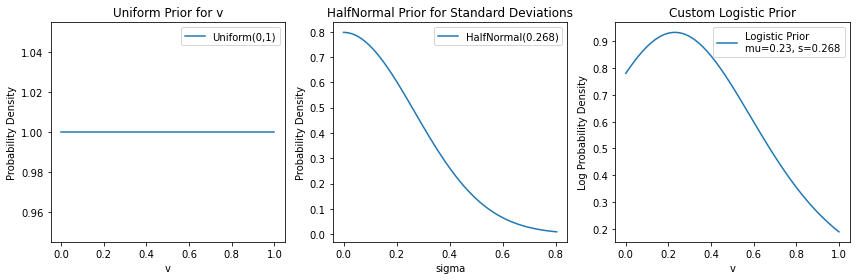

3SWetrRpRJdKgPEMPoRIclTnlsr2


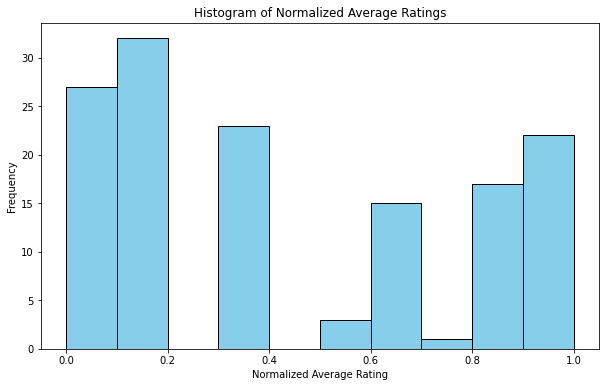

Estimated Prior Mean: 0.4368690261904761
Estimated Prior Standard Deviation: 0.36264368026503363


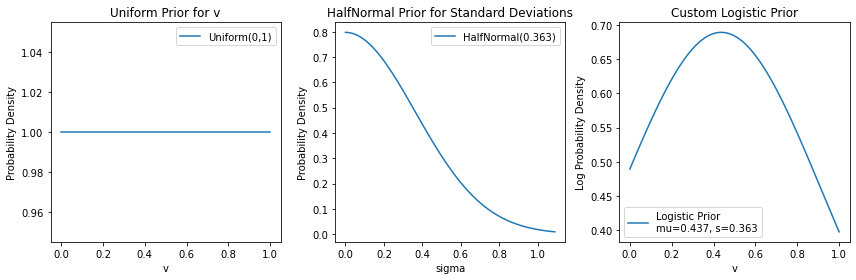

4G1tK8qkj0PHUfED8hXzqbo49BC2


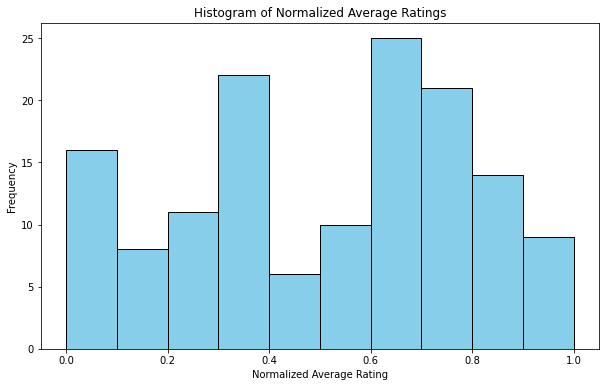

Estimated Prior Mean: 0.5130516784037559
Estimated Prior Standard Deviation: 0.28353191263466015


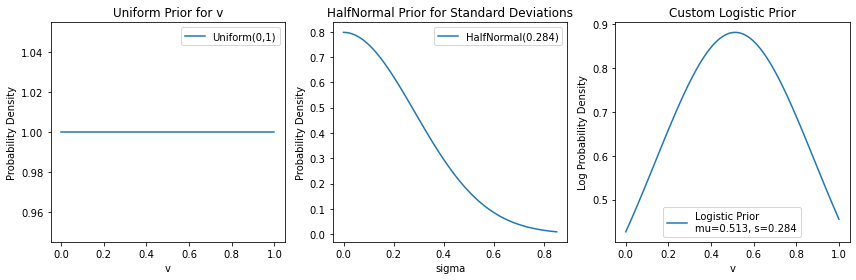

7ghYKTqtrhaaaW67UgOhb8Cbd2I3


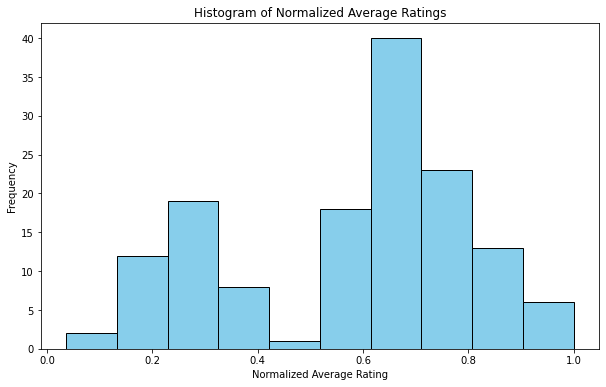

Estimated Prior Mean: 0.5778051572769952
Estimated Prior Standard Deviation: 0.23352594361388299


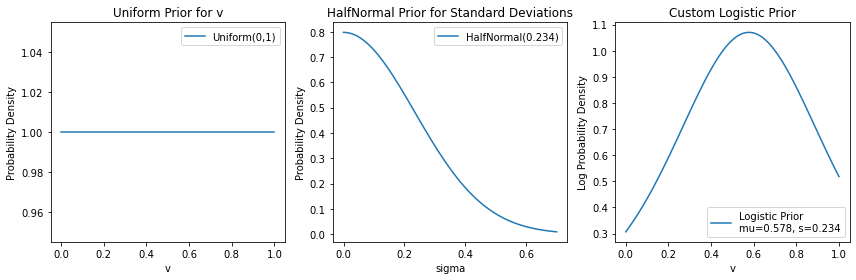

7j8j942HSdQaDvRaDOAPy3JtvlC3


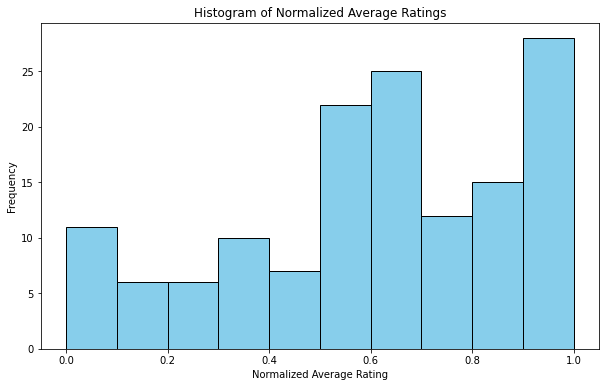

Estimated Prior Mean: 0.6143778215962442
Estimated Prior Standard Deviation: 0.29187337274943453


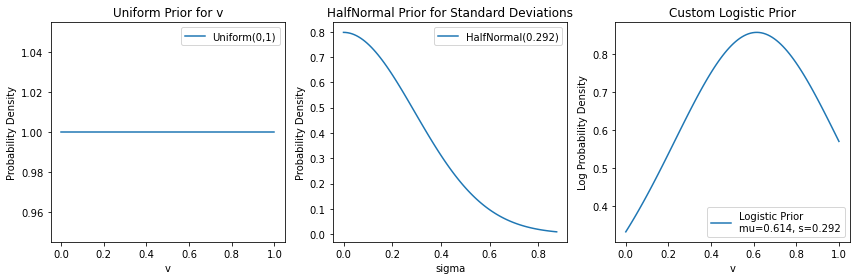

B4EwnLvbSsaeNpwR46fXntenwYv1


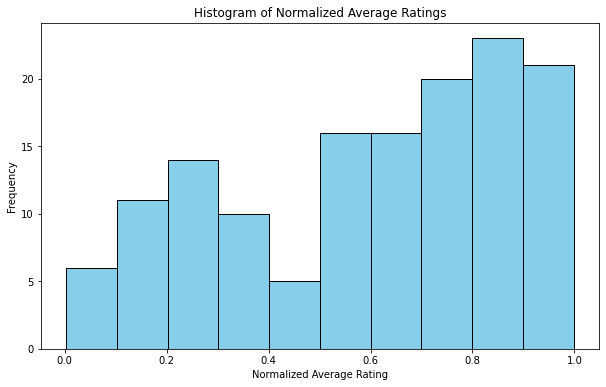

Estimated Prior Mean: 0.5989671361502346
Estimated Prior Standard Deviation: 0.2818247791840004


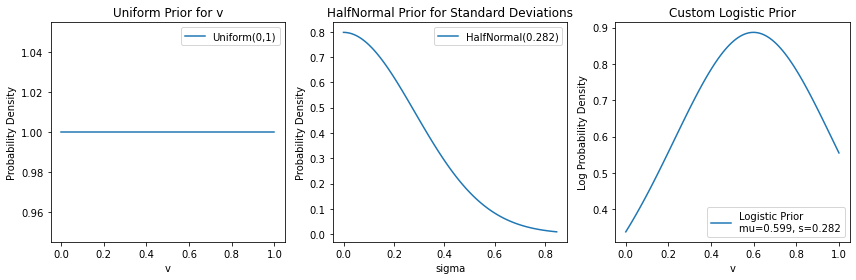

B5iqxuyY6fPlhuLWxUMvHG30eqP2


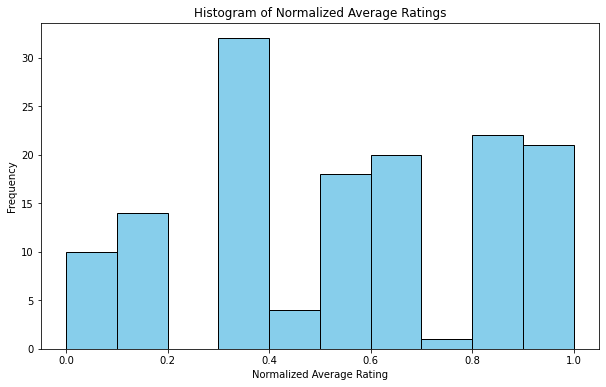

Estimated Prior Mean: 0.5468778568075118
Estimated Prior Standard Deviation: 0.30362908092979196


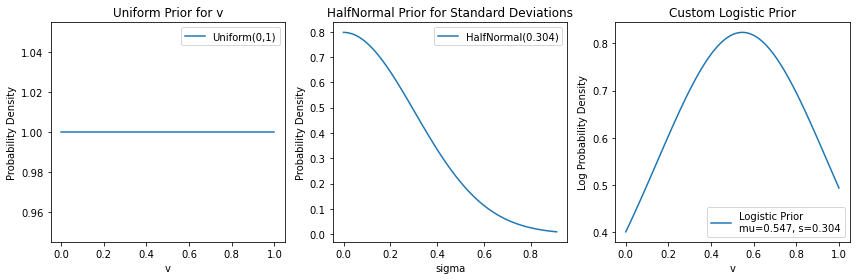

DdVjDGevouh5QWIsa8cVRwb5alV2


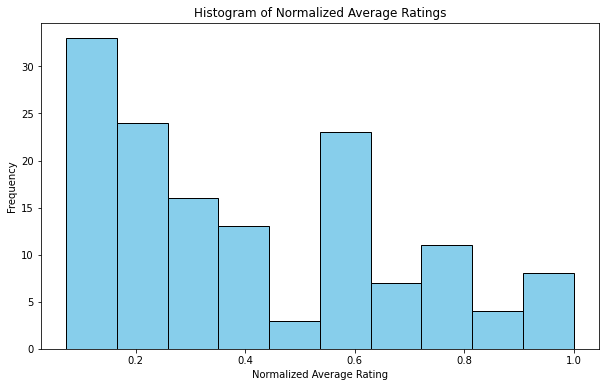

Estimated Prior Mean: 0.4070422464788734
Estimated Prior Standard Deviation: 0.25937034905884243


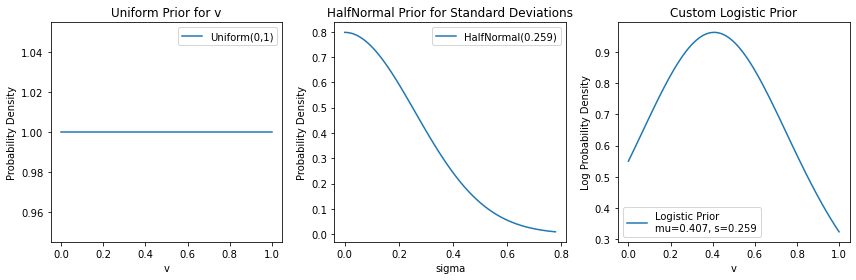

F9hEyhHx2UcDoYq9p4H28cHBXRa2


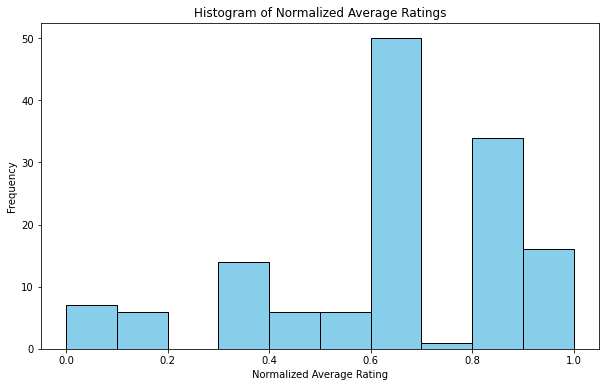

Estimated Prior Mean: 0.6413689904761907
Estimated Prior Standard Deviation: 0.25678488627234425


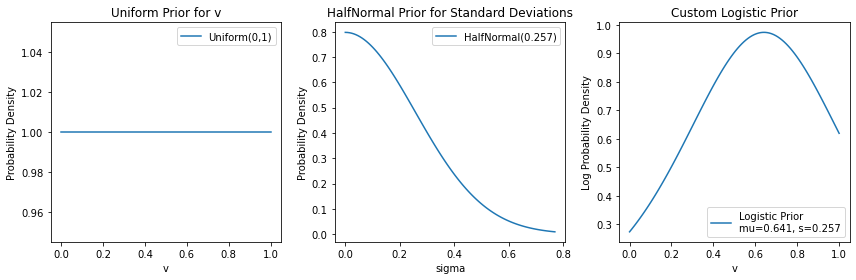

FJwRXjlNrSMDcuMS7XU9q5dXtQD3


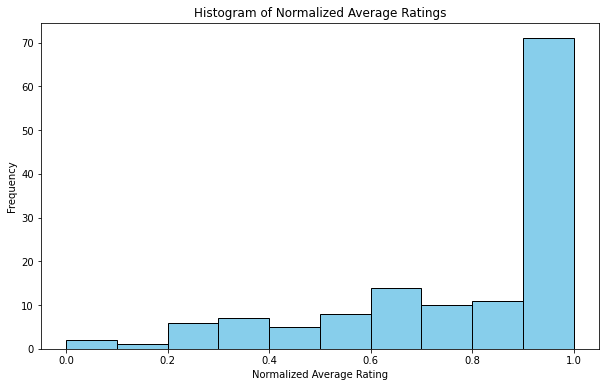

Estimated Prior Mean: 0.7947404962962967
Estimated Prior Standard Deviation: 0.25705082611282676


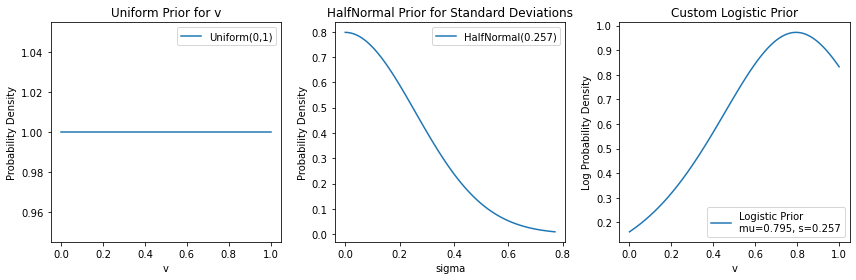

FnJPzkxAJmNUj2GeuPdhGi84TaS2


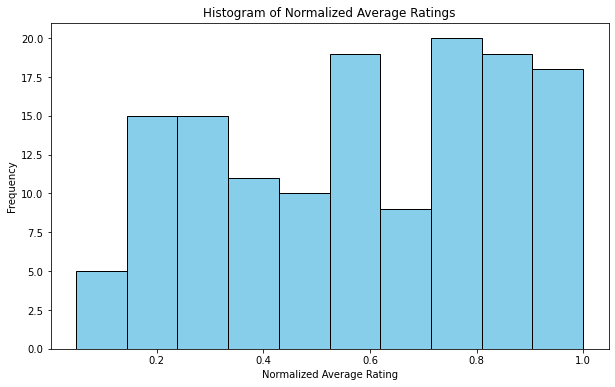

Estimated Prior Mean: 0.5808273806146573
Estimated Prior Standard Deviation: 0.2700747044434705


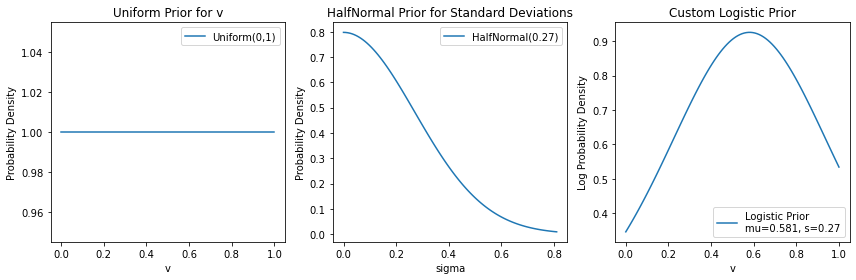

FzSIO4jBaMMX8PtwPc3OuED0XHk1


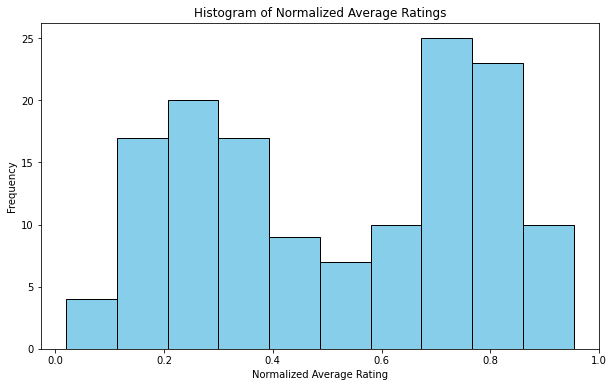

Estimated Prior Mean: 0.5177934272300471
Estimated Prior Standard Deviation: 0.26572310529529936


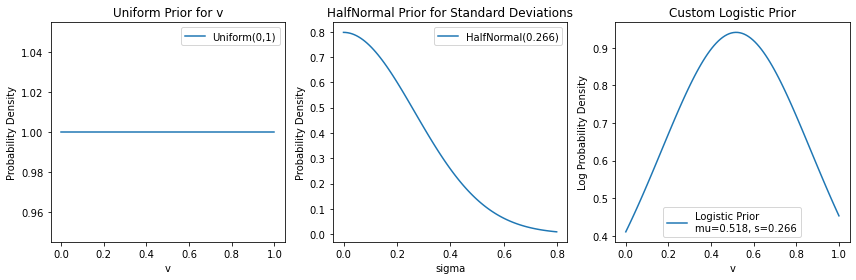

G2pa7YpR20hqGgcVzCFAgSlzNM63


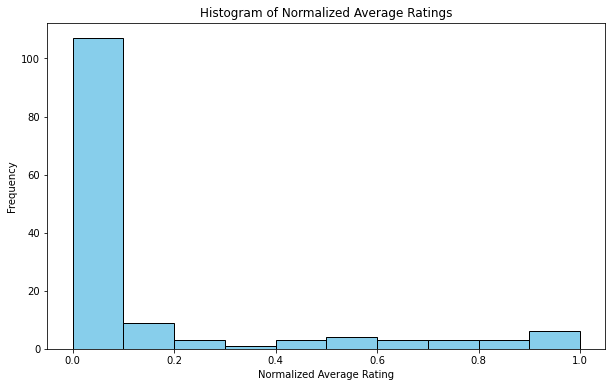

Estimated Prior Mean: 0.13626816901408456
Estimated Prior Standard Deviation: 0.27556296163771427


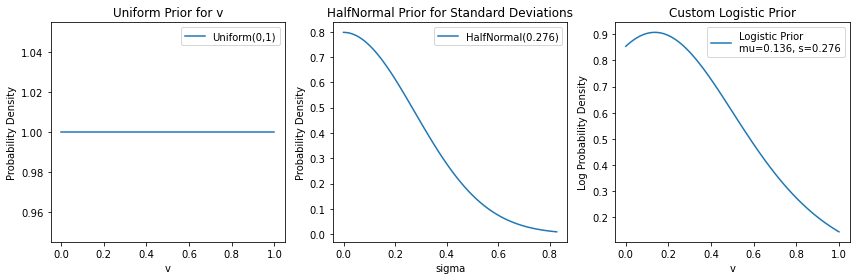

GOSiAkXddtOdOQ1gIpwnmuuvI1X2


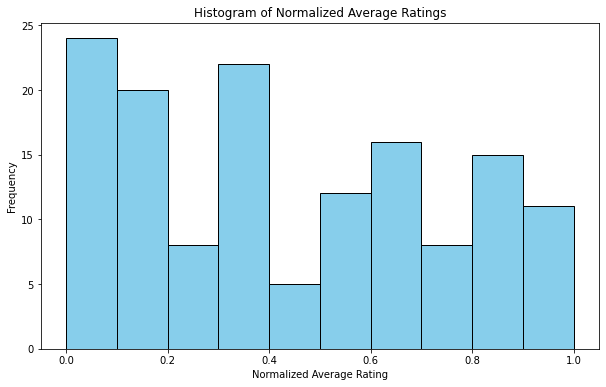

Estimated Prior Mean: 0.4412175579196217
Estimated Prior Standard Deviation: 0.3144388204740022


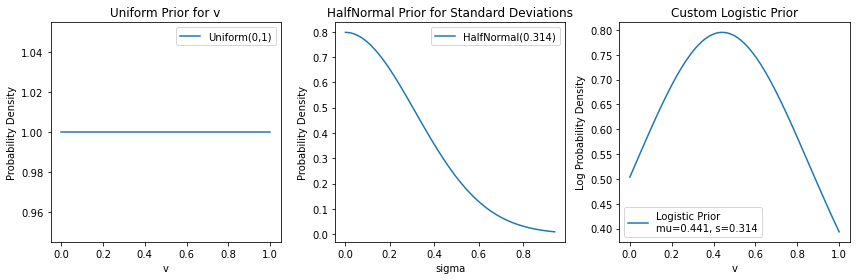

HEXtb5KaODhvdEcPZmsgsMZntR32


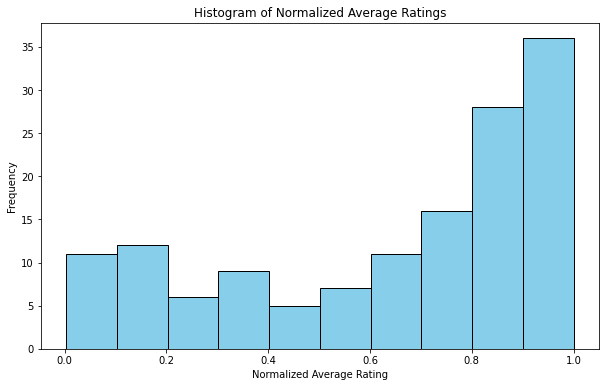

Estimated Prior Mean: 0.6426359196217495
Estimated Prior Standard Deviation: 0.3126954562544306


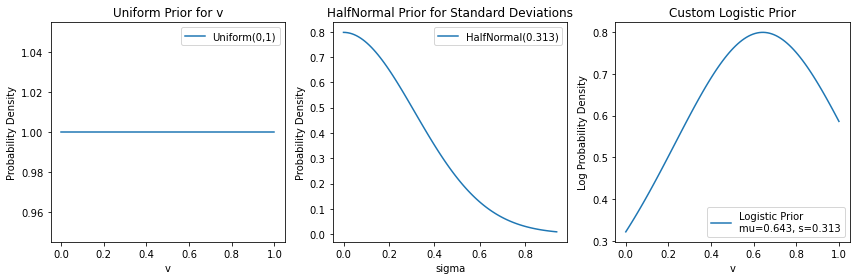

HlaWnAMQCNMZ4qbDwC0URV37BN42


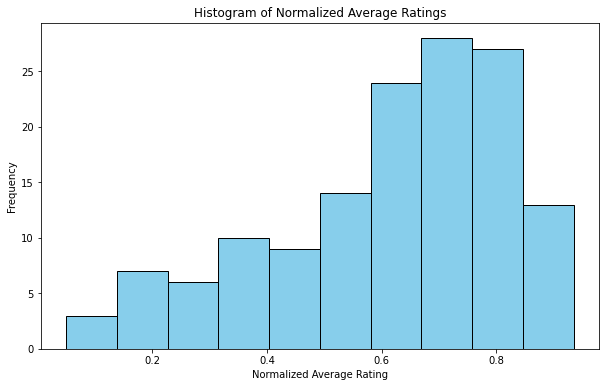

Estimated Prior Mean: 0.6111229314420802
Estimated Prior Standard Deviation: 0.20829413883251782


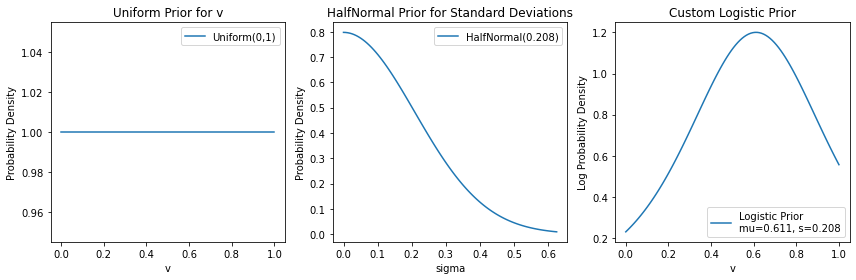

ImtyU7Np9RZdaz4zDybL67yuJrB3


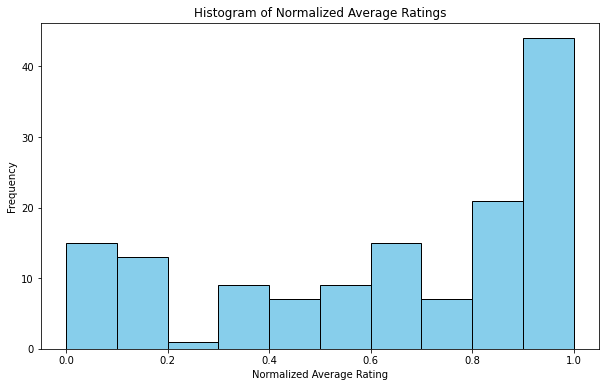

Estimated Prior Mean: 0.6362764680851068
Estimated Prior Standard Deviation: 0.344347918453897


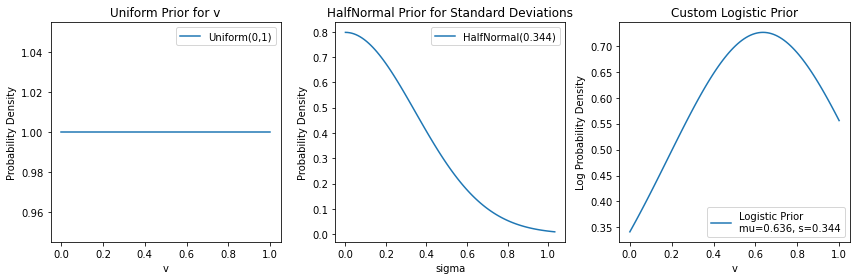

JhCnJQKEqWXP9RwyLVQ83OPZVDL2


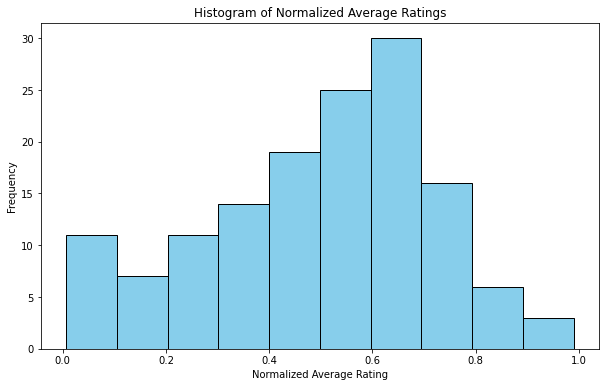

Estimated Prior Mean: 0.50231220657277
Estimated Prior Standard Deviation: 0.22819769129358827


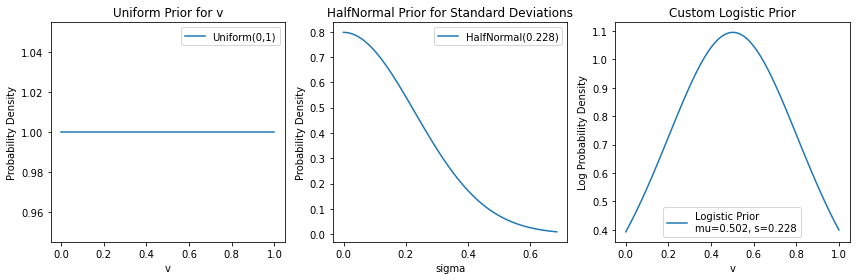

L2lfgllnanNfeMwA9f0RtADGboc2


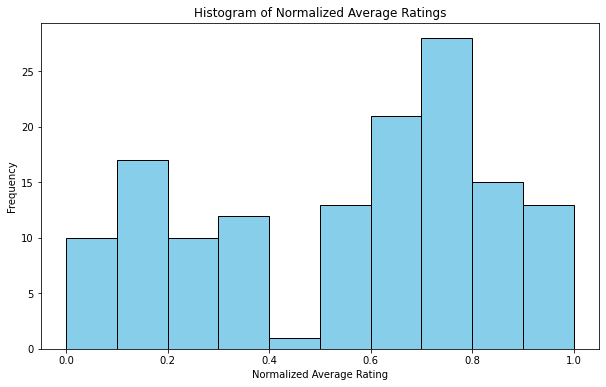

Estimated Prior Mean: 0.5520833404761903
Estimated Prior Standard Deviation: 0.2881328468261025


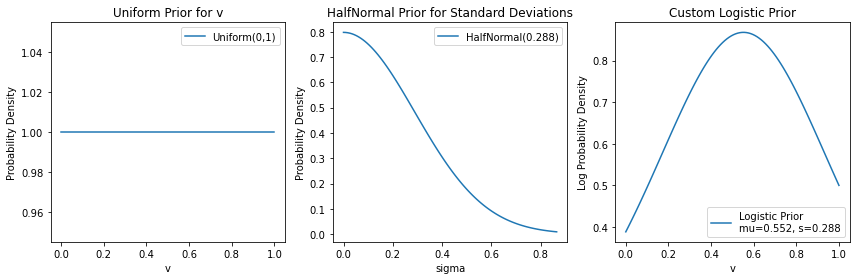

O4mOO2W80Od34gyNg7l6hJzqlDm2


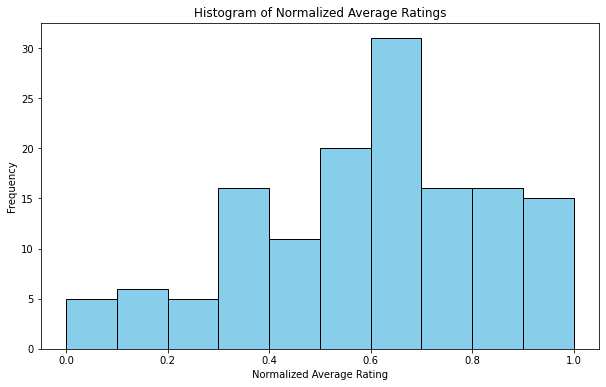

Estimated Prior Mean: 0.5991725200945626
Estimated Prior Standard Deviation: 0.24621857544499784


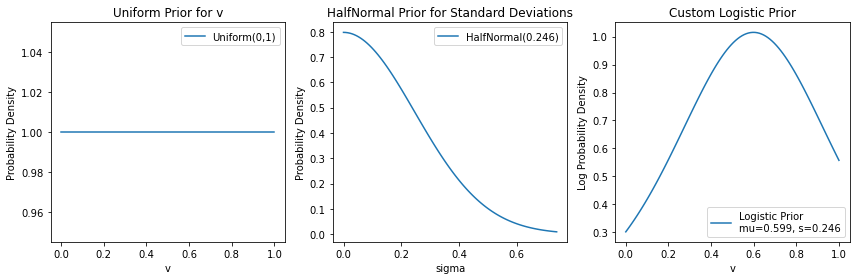

OUa8ld4IAidRoR512OAUH1C2JRb2


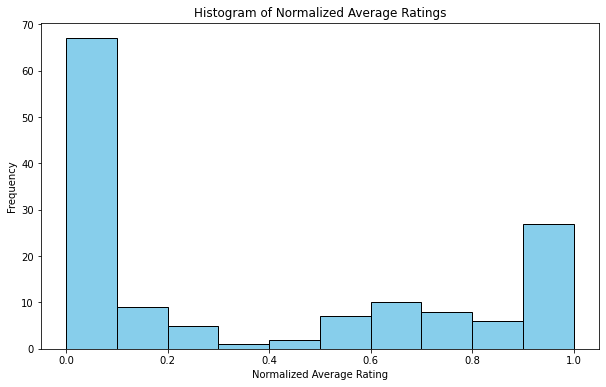

Estimated Prior Mean: 0.37254705399061017
Estimated Prior Standard Deviation: 0.4000740732201722


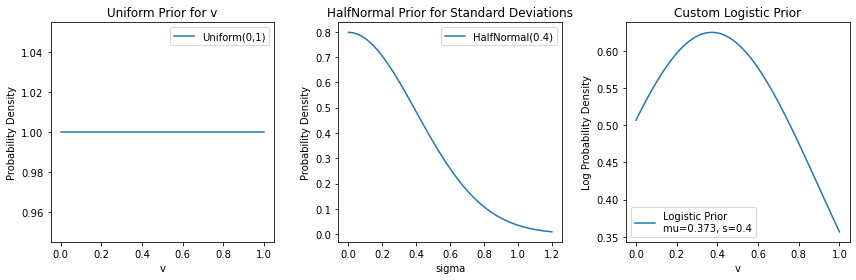

PCBVdAw8whSRxUxDm0KXMGruo102


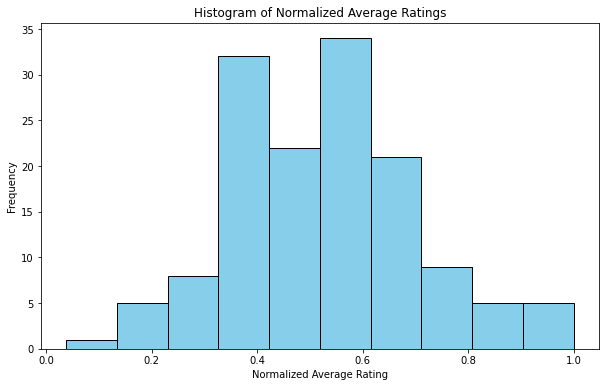

Estimated Prior Mean: 0.5255164248826291
Estimated Prior Standard Deviation: 0.17764571176357183


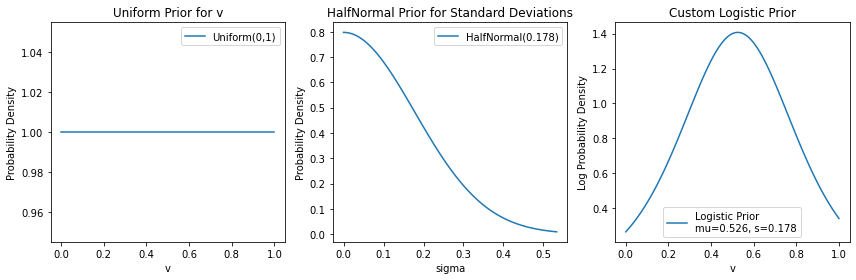

Piy5vZ3YFVbXWkAUPK8LB1NQK433


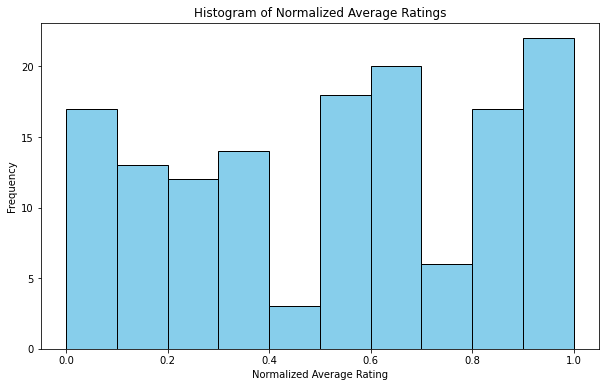

Estimated Prior Mean: 0.5277464436619721
Estimated Prior Standard Deviation: 0.316516467248932


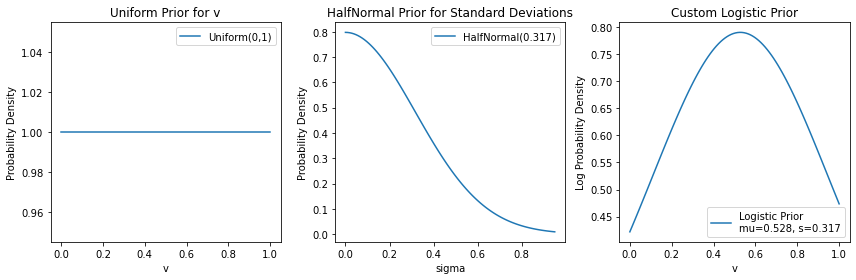

Ti7ZjpP6UTYpEKeqHiMO7caR0zJ2


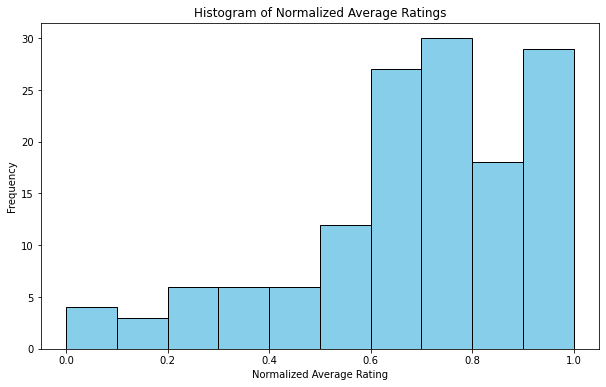

Estimated Prior Mean: 0.6874231465721039
Estimated Prior Standard Deviation: 0.2371580594090817


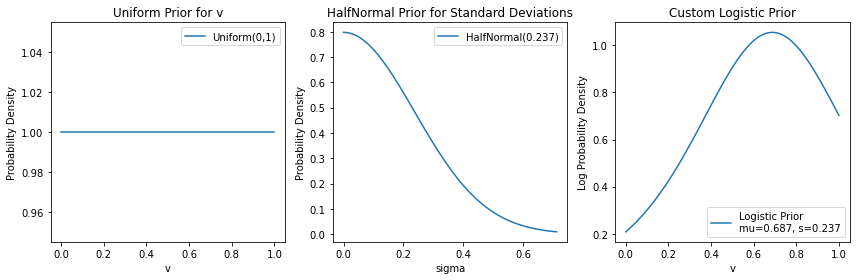

UYOG7BpRTVMWaq9SYiEf3oAHUSG3


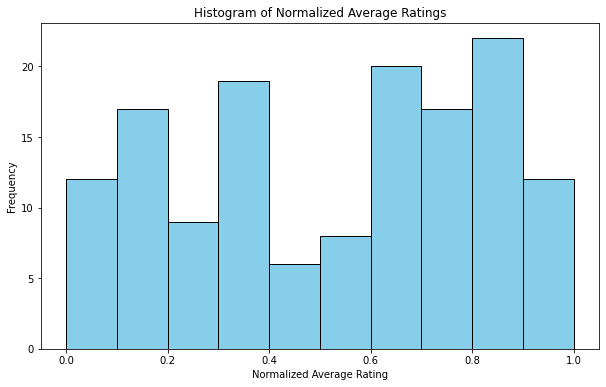

Estimated Prior Mean: 0.5226643262910801
Estimated Prior Standard Deviation: 0.29158479173019763


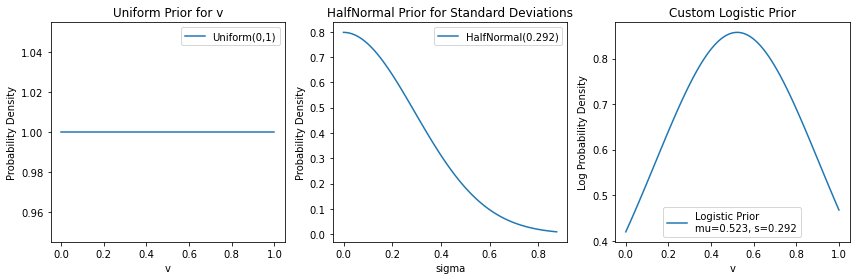

UlG7rL2eqhZlQwZRPFKtzDXh9So1


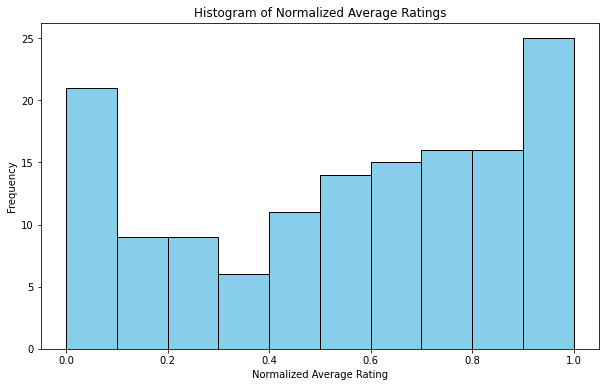

Estimated Prior Mean: 0.5546830845070421
Estimated Prior Standard Deviation: 0.32395846884729534


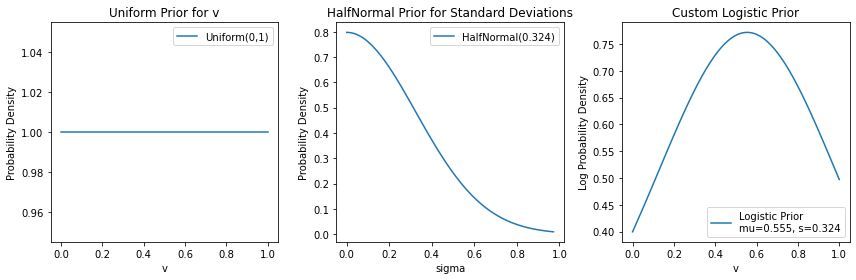

ZkDVh1wELvQX1D6HHSTLkWoaEWy1


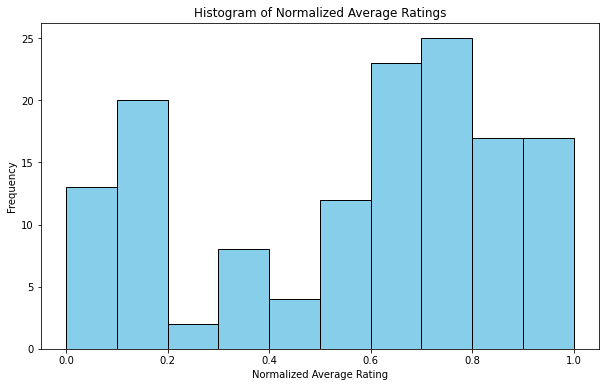

Estimated Prior Mean: 0.5629432624113473
Estimated Prior Standard Deviation: 0.30003464338991576


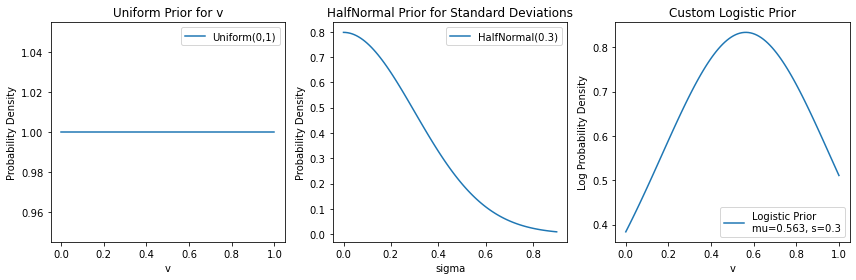

aoee4EeXKFMjaH2Kj9IpJu6eC1I3


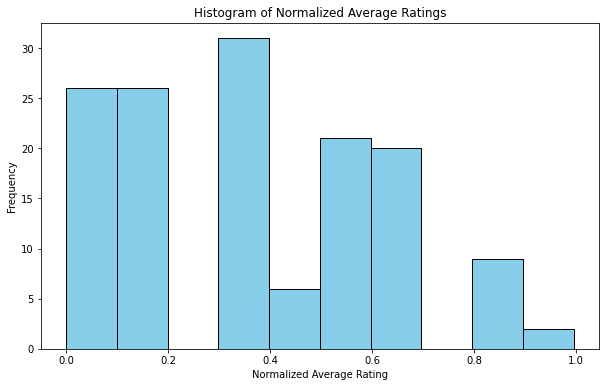

Estimated Prior Mean: 0.36381814420803765
Estimated Prior Standard Deviation: 0.264665352090496


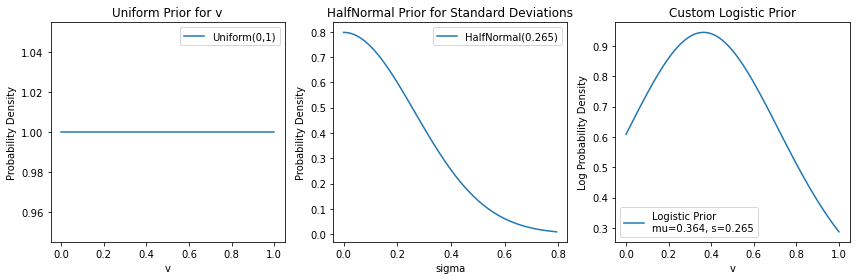

cOGoVG6nRrfmZFFNsDYm55hT8Bx2


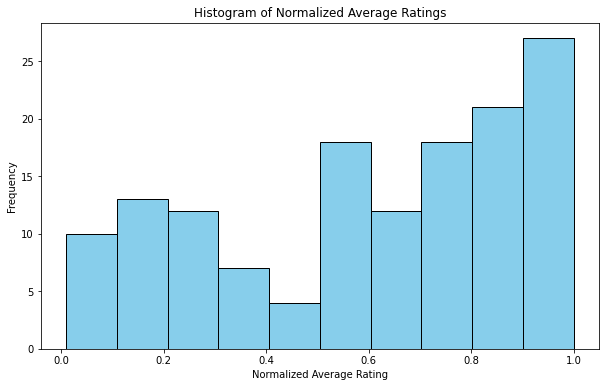

Estimated Prior Mean: 0.6012675985915494
Estimated Prior Standard Deviation: 0.29844902375563687


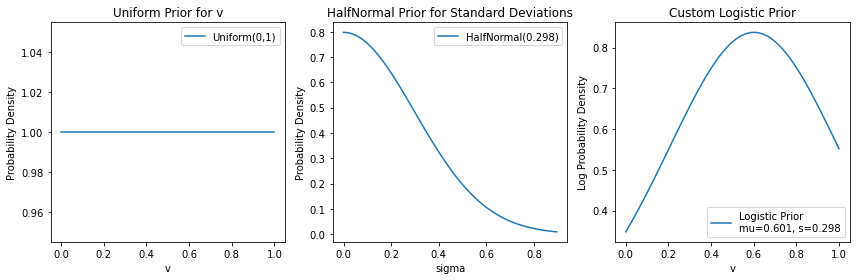

cwwgh8go5nRH64TkhaCbD8vGfLJ2


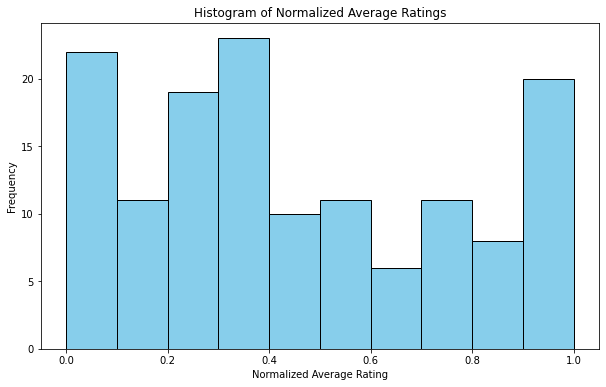

Estimated Prior Mean: 0.45546099290780123
Estimated Prior Standard Deviation: 0.31458610918886937


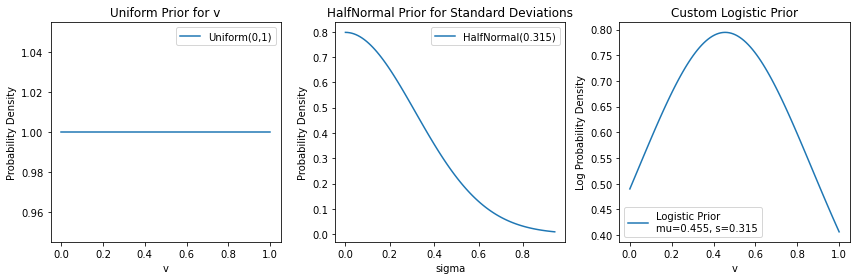

eu2wMkhOS9PFoxKnXIdMi9r3sl43


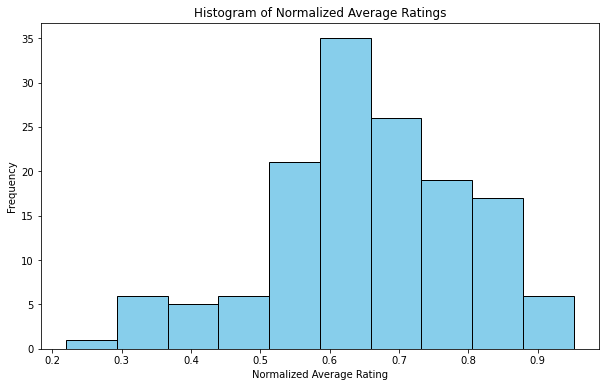

Estimated Prior Mean: 0.6546478873239434
Estimated Prior Standard Deviation: 0.1452362591119449


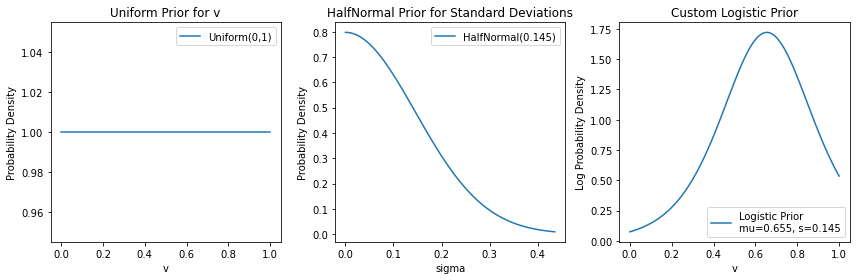

ewxBnQfElFSdysOhHH8VjNfDrLb2


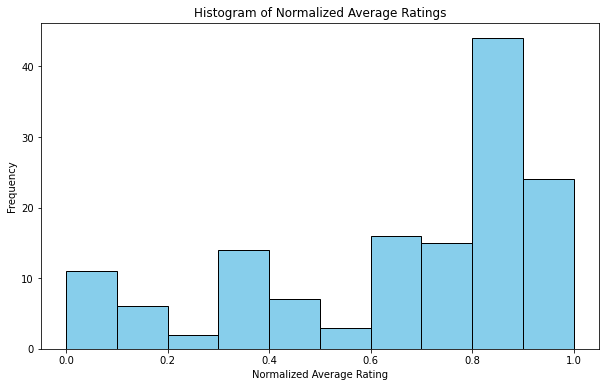

Estimated Prior Mean: 0.658802809859155
Estimated Prior Standard Deviation: 0.28689795519814526


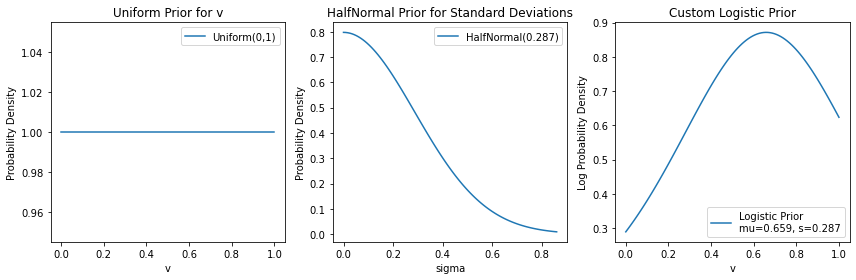

fMPR0LGhDWNbHzqc0Hg8lEPxK2F3


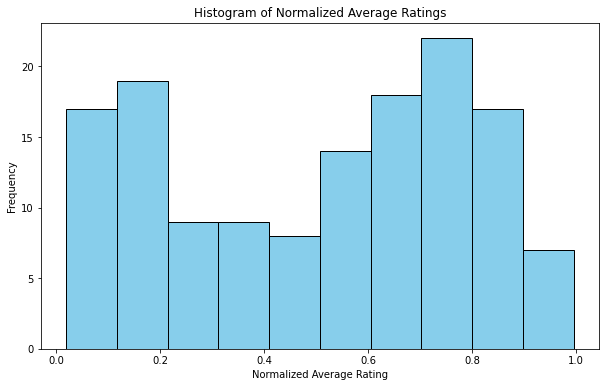

Estimated Prior Mean: 0.502940476190476
Estimated Prior Standard Deviation: 0.2901710272383041


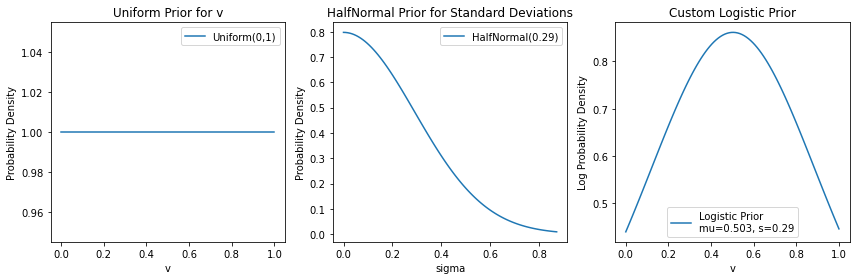

fwqIH1xrKwawDtwzfuQUKVUNTHx2


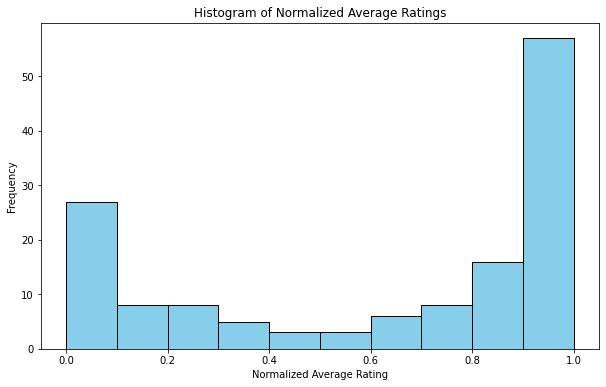

Estimated Prior Mean: 0.6230141418439717
Estimated Prior Standard Deviation: 0.389969230603883


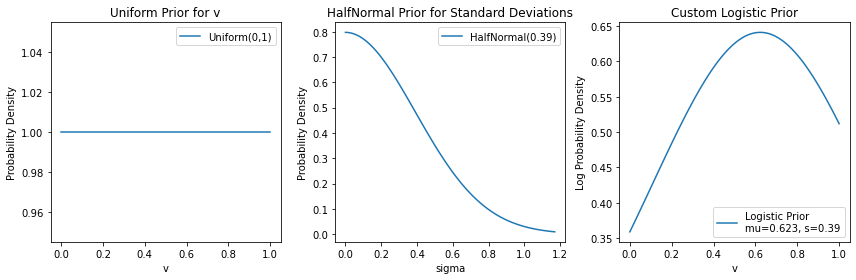

gmoV0YU5dfVFl3kdMKLHE1UMUgB3


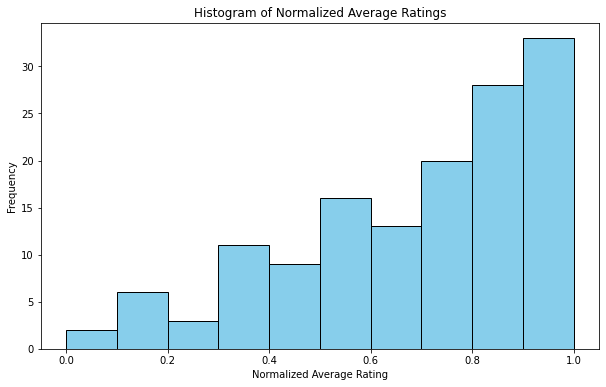

Estimated Prior Mean: 0.690851056737589
Estimated Prior Standard Deviation: 0.24620668064129192


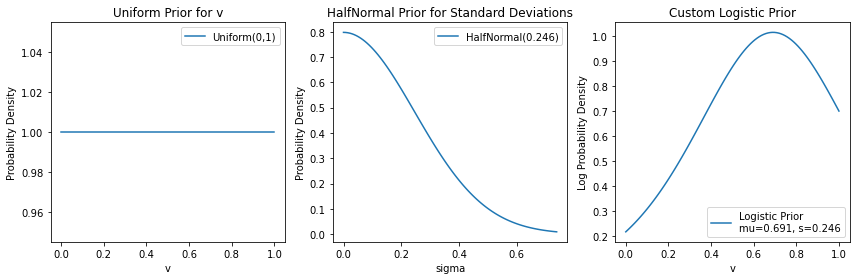

hUYlC7L8PacJnWEkofJFRPoTyiP2


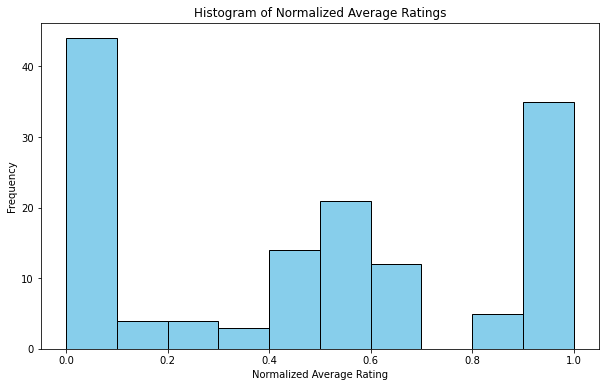

Estimated Prior Mean: 0.47892025117370873
Estimated Prior Standard Deviation: 0.3873542841249324


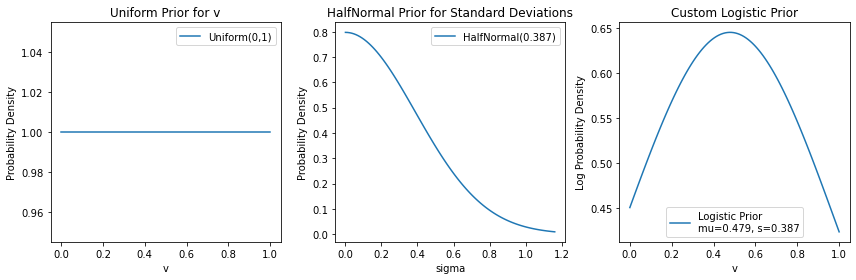

hWI3dFP8H9fLaC9nnJwvdTi5ana2


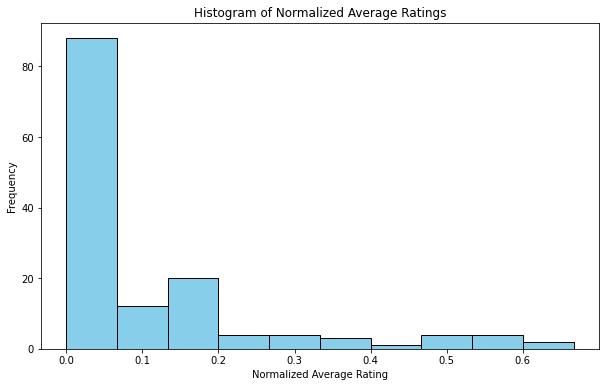

Estimated Prior Mean: 0.09805218544600924
Estimated Prior Standard Deviation: 0.15790382877834142


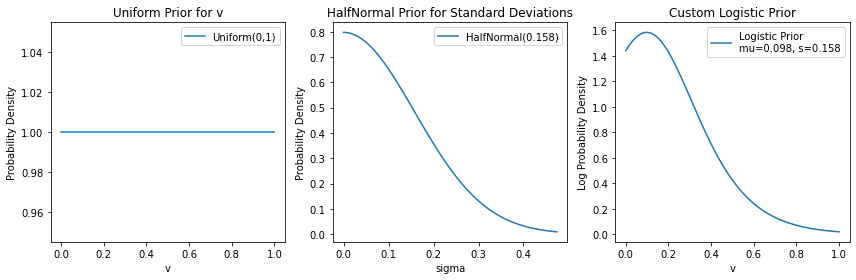

jtDqYVyiOqXI6LO1VTUcEpqhtFX2


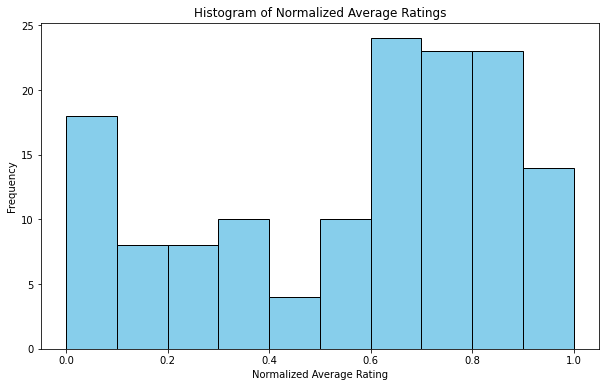

Estimated Prior Mean: 0.5661737159624414
Estimated Prior Standard Deviation: 0.3101191911559105


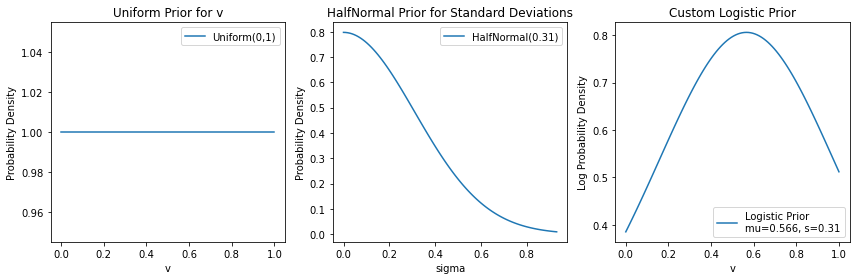

lB6NlbhmmHSgEuEpGts3XY24krc2


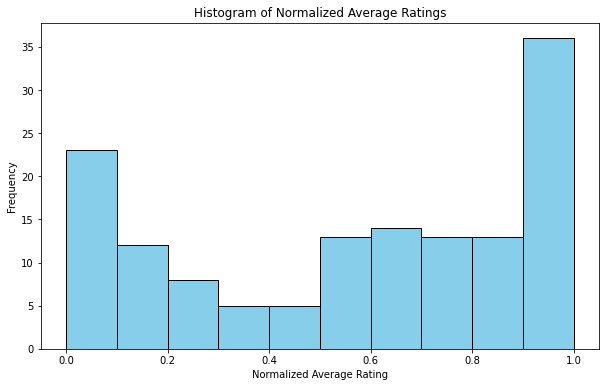

Estimated Prior Mean: 0.5679576901408451
Estimated Prior Standard Deviation: 0.3549577889248305


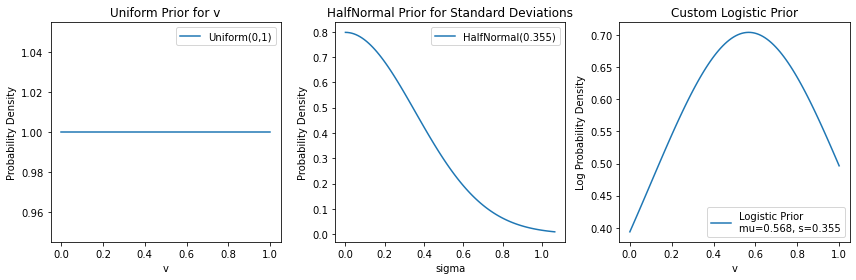

mT1kCjuDPpPKJM3doKxY4kc4BS02


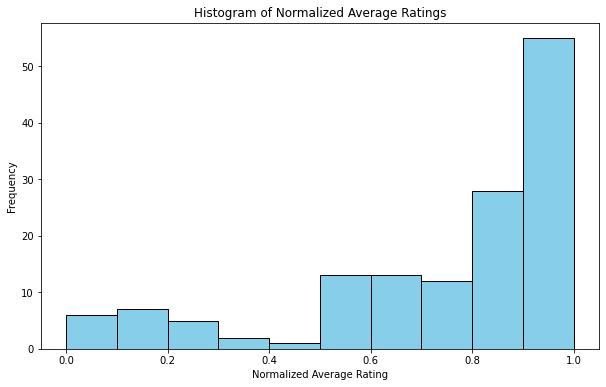

Estimated Prior Mean: 0.7465609061032864
Estimated Prior Standard Deviation: 0.28350959421537947


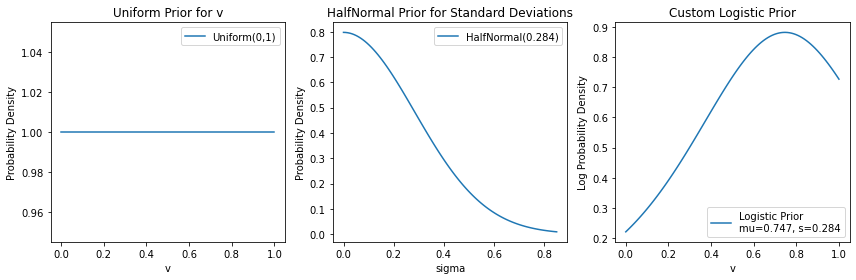

p6Va7ibsTxT53JJxw7Uh5Eo8qWP2


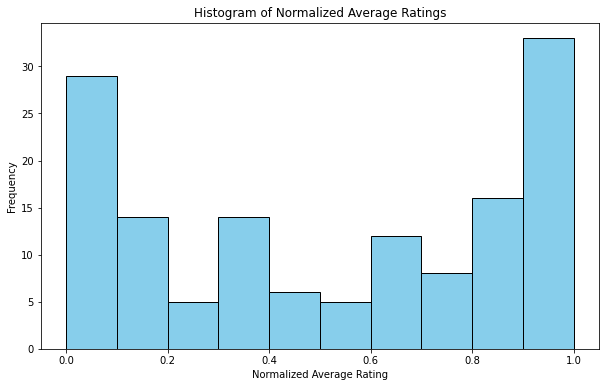

Estimated Prior Mean: 0.5208215962441314
Estimated Prior Standard Deviation: 0.3566485107550719


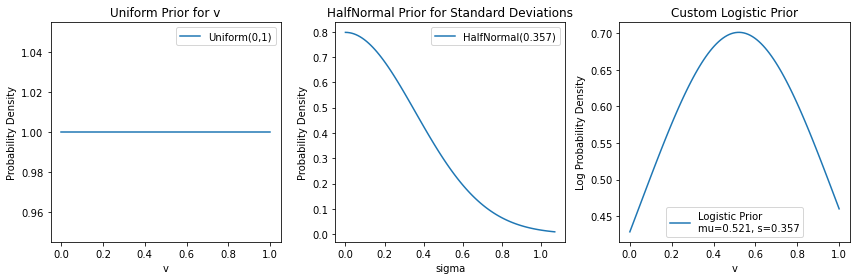

qmDjvMkxwoMJdQs99si3Kme0UcC2


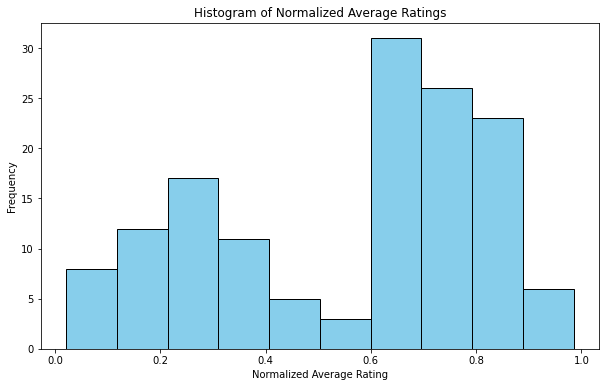

Estimated Prior Mean: 0.5549178403755869
Estimated Prior Standard Deviation: 0.26283246254488224


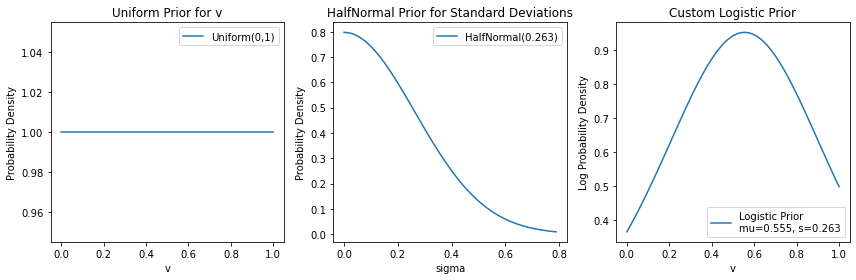

rsVim6tqIpOqvYDw1jMfZzuVHtw2


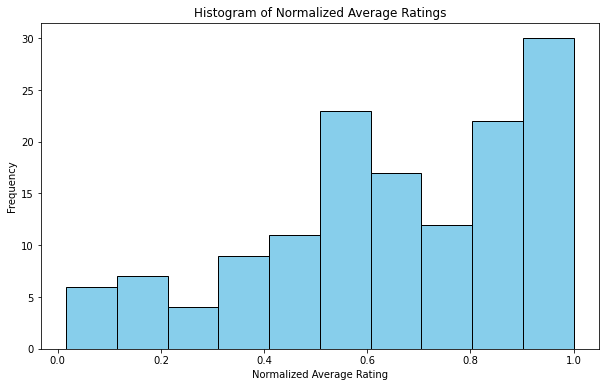

Estimated Prior Mean: 0.6503190992907802
Estimated Prior Standard Deviation: 0.26215393164503026


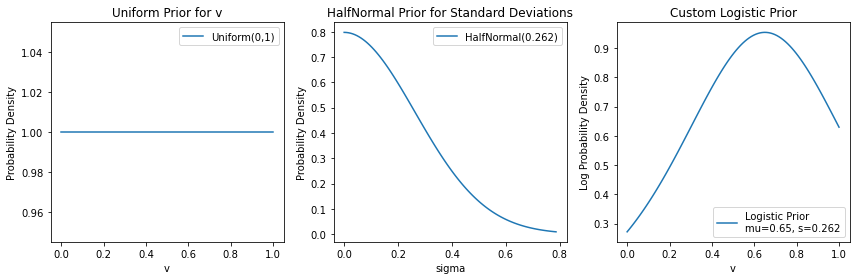

s5ZQO7s4JcbMwZbx9faFWEP5zoa2


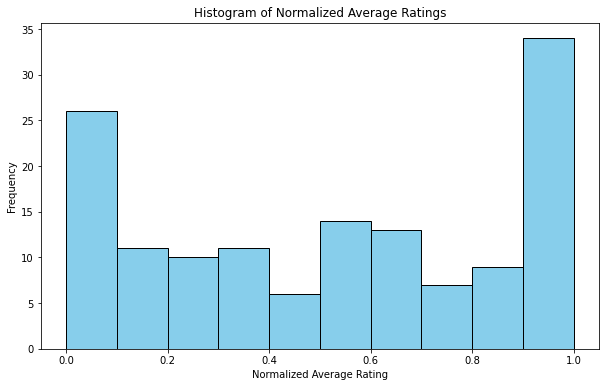

Estimated Prior Mean: 0.5231323735224584
Estimated Prior Standard Deviation: 0.35134793792687086


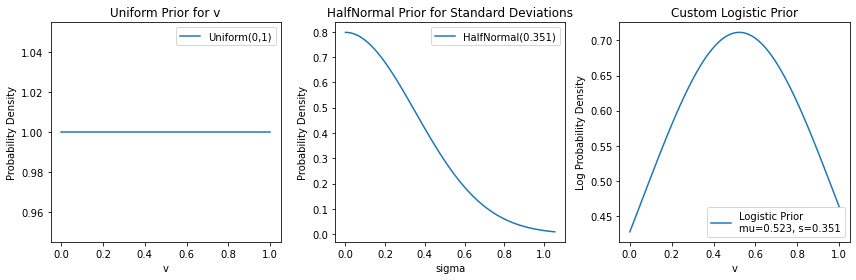

tCNOnKHIKhXJ8S2ICfZyxjcgFka2


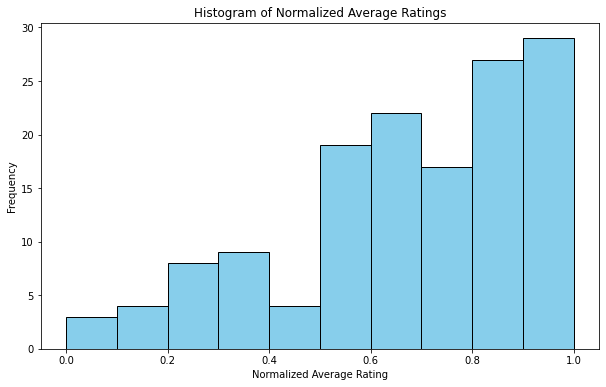

Estimated Prior Mean: 0.6699765046948355
Estimated Prior Standard Deviation: 0.2464635024849971


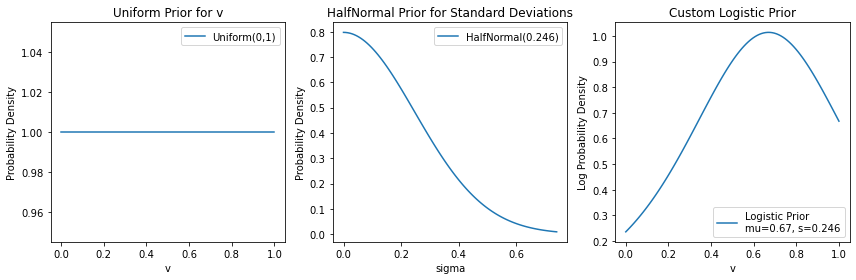

twxyI2Kt58fbZ4hfwm9UNceGekR2


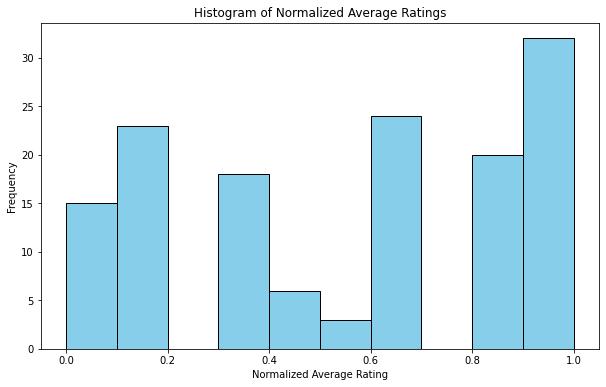

Estimated Prior Mean: 0.5570448392434988
Estimated Prior Standard Deviation: 0.35072766617608037


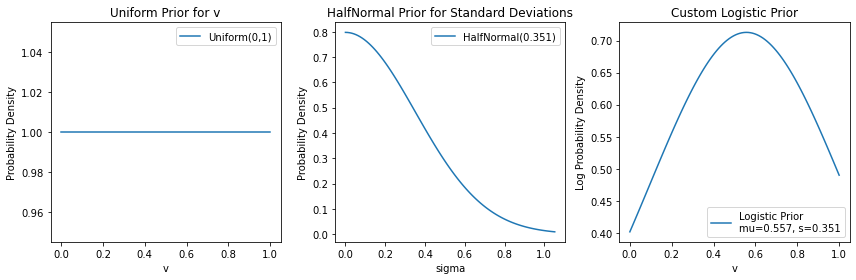

uWKJMnyXNsfpl1rbhlaS2kBk6EB2


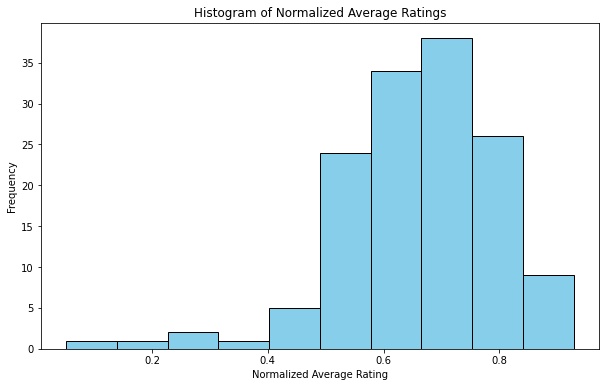

Estimated Prior Mean: 0.6628723404255319
Estimated Prior Standard Deviation: 0.13694427472617082


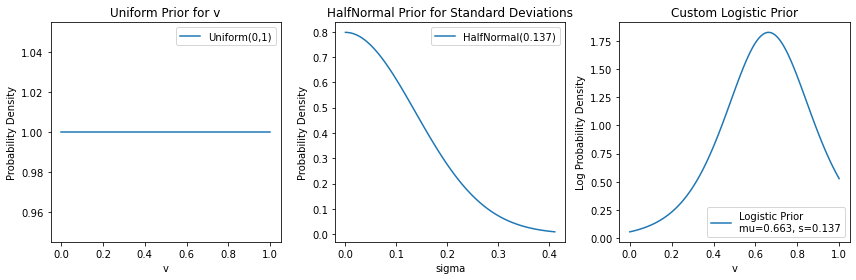

v1YJ7EKlcFYhpoToZJgLzd7nTIB3


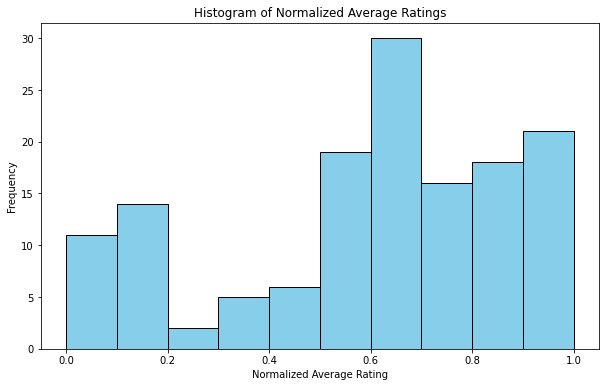

Estimated Prior Mean: 0.598978873239437
Estimated Prior Standard Deviation: 0.2869544495744294


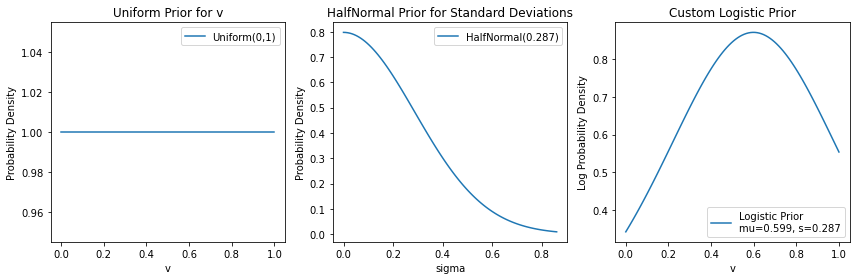

vOgEhaZeRWXEAL52dY4a7sqOHI12


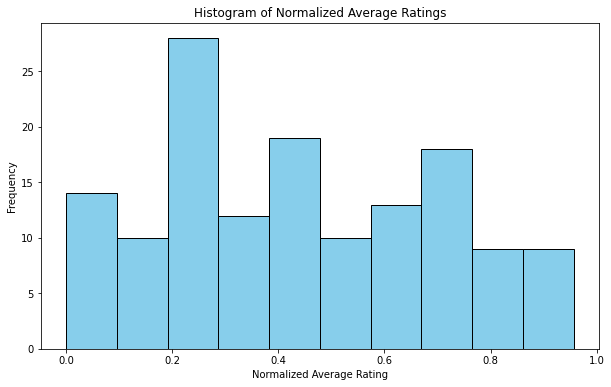

Estimated Prior Mean: 0.44386151643192484
Estimated Prior Standard Deviation: 0.25816669300397915


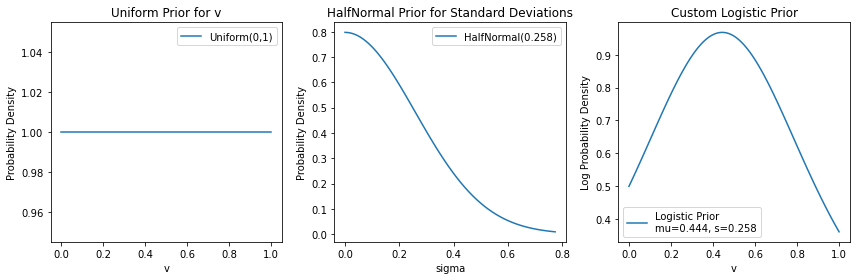

vTreiIt2JuefuP24EEhz5QRXwyq2


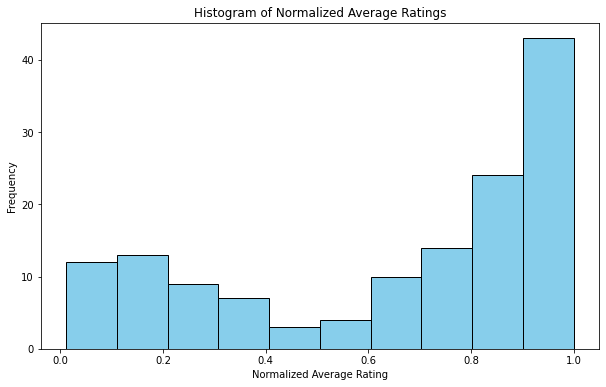

Estimated Prior Mean: 0.6502517769784171
Estimated Prior Standard Deviation: 0.3240088650069954


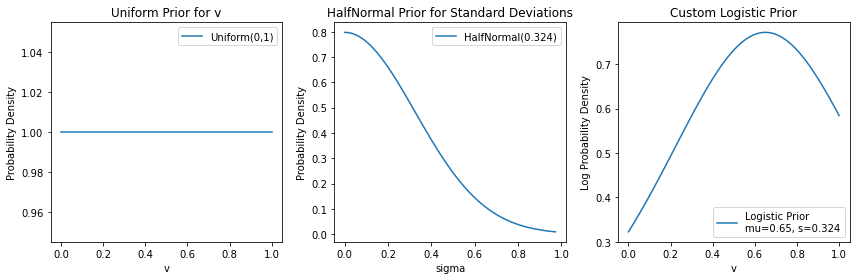

vgamw3spypQMYkVROFbxlK0Ov913


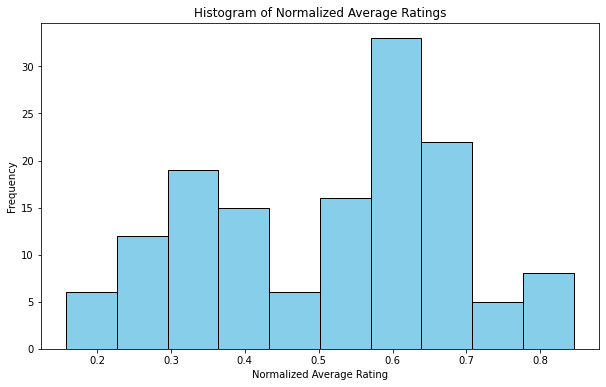

Estimated Prior Mean: 0.5142253521126762
Estimated Prior Standard Deviation: 0.17178588001512282


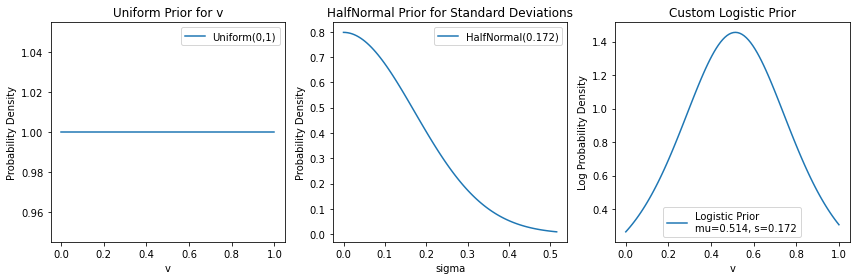

wU0Fc8fk2eR5Vcd6rpYFostZM2n2


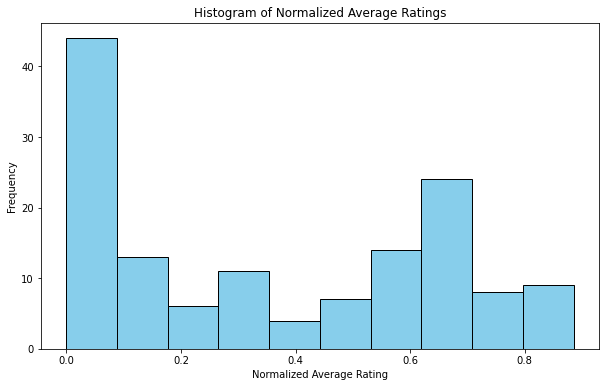

Estimated Prior Mean: 0.35672635476190456
Estimated Prior Standard Deviation: 0.292507930780244


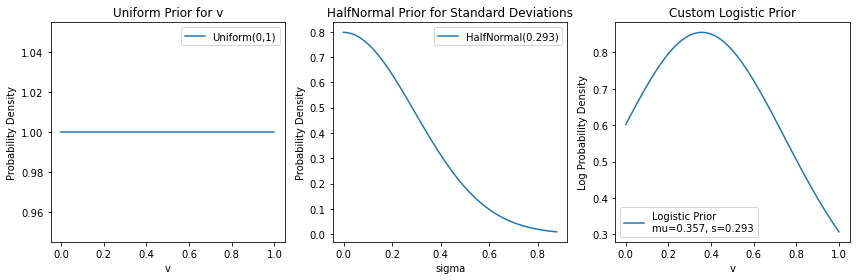

wj1yeADw05QlzaG1Sin8wuEse7x1


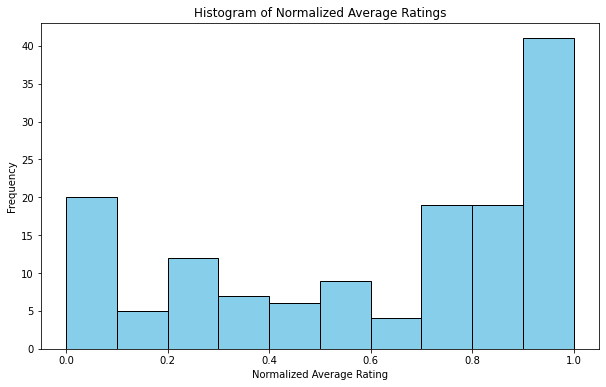

Estimated Prior Mean: 0.6118192417840378
Estimated Prior Standard Deviation: 0.3388225152138358


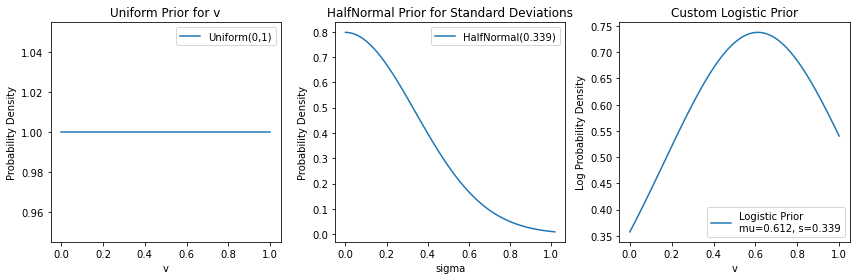

yVa0rsMhhzbz3akLkNeXRwDY04x1


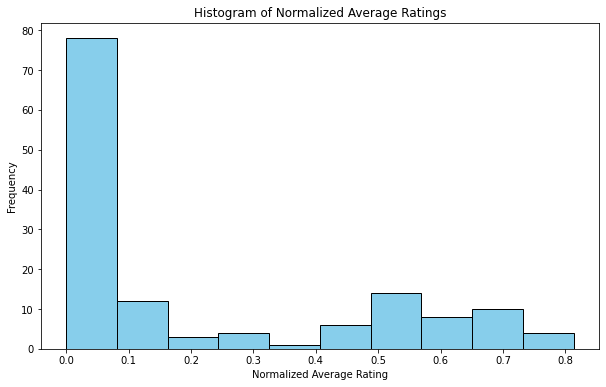

Estimated Prior Mean: 0.20802430952380976
Estimated Prior Standard Deviation: 0.271523688929536


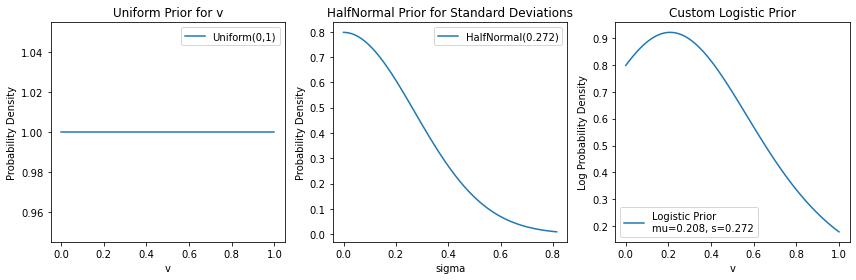

zLcfAt5xrpdA2kcYs0IcClMICgn2


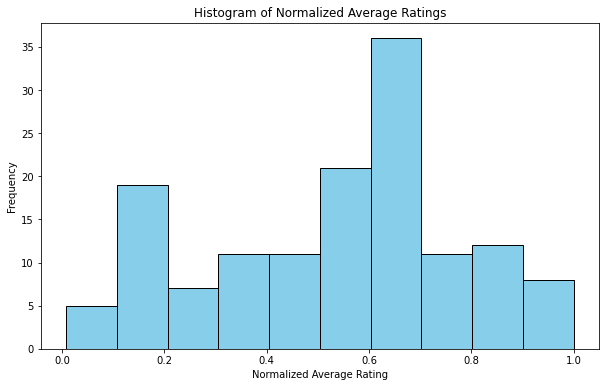

Estimated Prior Mean: 0.5320921914893617
Estimated Prior Standard Deviation: 0.24498657525648293


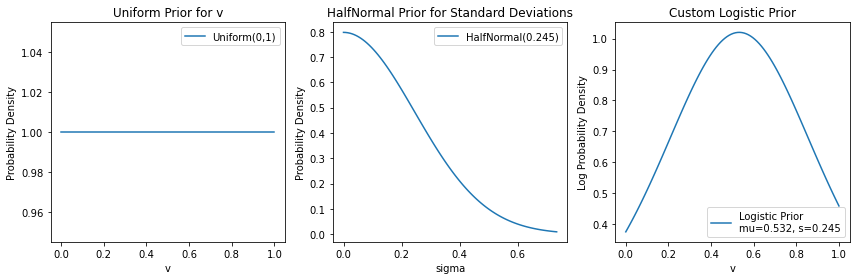

zXLYz9BUjadupX3q7gqaPMBYD152


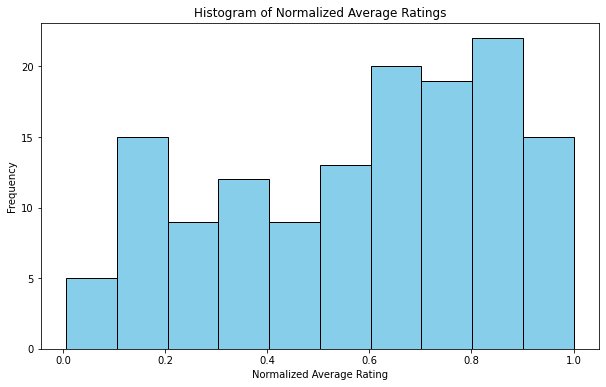

Estimated Prior Mean: 0.5834412398081534
Estimated Prior Standard Deviation: 0.27125068613581693


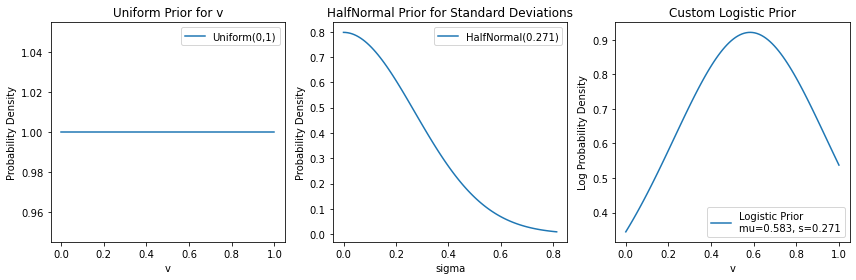

In [17]:
# Small jitter value
epsilon = 1e-6
for participant in all_participants: 
    print(participant)

    participant_emo = all_data_emo[all_data_emo["subject_id"] == participant].copy()

    # Define the parameters for the prior distribution
    # Normalize the 'average_rating' to a 0-1 scale
    participant_emo.loc[:, 'normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
    participant_emo.loc[:, 'normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)
    
    # Jitter for every participant
    participant_emo.loc[:, 'normalized_rating_phase1'] = participant_emo.loc[:, 'normalized_rating_phase1'].apply(
            lambda x: 0 + epsilon if x == 0 else (1 - epsilon if x == 1 else x)
        )
    participant_emo.loc[:, 'normalized_rating_phase2'] = participant_emo.loc[:, 'normalized_rating_phase2'].apply(
            lambda x: 0 + epsilon if x == 0 else (1 - epsilon if x == 1 else x)
        )


    # Compute the average of the normalized ratings
    participant_emo.loc[:, 'normalized_average_rating'] = participant_emo.loc[:, ['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)     

    # Jitter ratings where ratings are equal to 1 or 0
#     #  0 or 1 - an issue with logarithms or inverses -> can become undefined or lead to numerical instability (g(v))
#     if participant_emo["normalized_average_rating"].max() == 1 or participant_emo["normalized_average_rating"].min() == 0:

#         participant_emo['normalized_average_rating'] = participant_emo['normalized_average_rating'].apply(
#             lambda x: 0 + epsilon if x == 0 else (1 - epsilon if x == 1 else x)
#         )
    
    # Jitter for every participant
#     participant_emo['normalized_average_rating'] = participant_emo['normalized_average_rating'].apply(
#             lambda x: 0 + epsilon if x == 0 else (1 - epsilon if x == 1 else x)
#         )
    
#     # Clip data to avoid boundaries
#     participant_emo['normalized_average_rating'] = clip_data(participant_emo['normalized_average_rating'], lower=epsilon, upper=1-epsilon)

#     # Squeeze data to avoid boundaries for every participant
#     participant_emo['normalized_average_rating'] = squeeze_data(participant_emo['normalized_average_rating'], lower=epsilon, upper=1-epsilon)

    # Compute the variability of the normalized ratings
    participant_emo.loc[:, 'normalized_variance_rating'] = participant_emo.loc[:, ['normalized_rating_phase1', 'normalized_rating_phase2']].std(axis=1)


    # Extract the number of videos 
    num_videos = len(participant_emo)


    # Plot of 'normalized_average_rating' so normalized average ratings on anxiety for participant of focus 
    plt.figure(figsize=(10, 6))
    plt.hist(participant_emo['normalized_average_rating'], bins=10, color='skyblue', edgecolor='black')
    plt.title('Histogram of Normalized Average Ratings')
    plt.xlabel('Normalized Average Rating')
    plt.ylabel('Frequency')
    plt.show()

    # Calculate new parameters on the normalized scale
    mu_empirical = participant_emo['normalized_average_rating'].mean()
    s_empirical = participant_emo['normalized_average_rating'].std()

    print("Estimated Prior Mean:", mu_empirical)
    print("Estimated Prior Standard Deviation:", s_empirical)

    # Plot priors for visualization 
    # Define the range for v
    v_values = np.linspace(0, 1, 100)

    # Plot Uniform distribution for v
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.plot(v_values, np.ones_like(v_values), label='Uniform(0,1)')
    plt.title('Uniform Prior for v')
    plt.xlabel('v')
    plt.ylabel('Probability Density')
    plt.legend()

    # Plot HalfNormal distribution for standard deviations
    sigma_values = np.linspace(0, 3 * s_empirical, 100)
    plt.subplot(1, 3, 2)
    plt.plot(sigma_values, (np.sqrt(2/np.pi) * np.exp(-0.5 * (sigma_values/s_empirical)**2)), label=f'HalfNormal({np.round(s_empirical,3)})')
    plt.title('HalfNormal Prior for Standard Deviations')
    plt.xlabel('sigma')
    plt.ylabel('Probability Density')
    plt.legend()

    plt.subplot(1, 3, 3)
    logistic_prior = logp_logistic_bis(v_values, mu_empirical, s_empirical)
    plt.plot(v_values, np.exp(logistic_prior), label=f'Logistic Prior\nmu={np.round(mu_empirical,3)}, s={np.round(s_empirical,3)}')
    plt.title('Custom Logistic Prior')
    plt.xlabel('v')
    plt.ylabel('Log Probability Density')
    plt.legend()

    plt.tight_layout()
    plt.show()

    try:
            # Bayesian model Setup
            with pm.Model() as model:
                # Prior distributions for parameters
                mu = pm.Normal('mu', mu=mu_empirical, sigma=s_empirical)
                s = pm.HalfNormal('s', sigma=s_empirical)
                sigma = pm.HalfNormal('sigma', sigma=1)
                sigma_ext = pm.HalfNormal('sigma_ext', sigma=1)

                # Observations
                # Convert simulated_noisy_ratings from a NumPy array to a Theano tensor by using it as observed data
                observed_noisy_ratings = pm.Data("observed_noisy_ratings", participant_emo['normalized_average_rating'])

                # Define the latent variable v with a logistic prior
                v = pm.Uniform('v', 0, 1, shape=num_videos)  # Starting with a Uniform prior for simplicity
                # Add the custom logistic prior using a Potential
                pm.Potential('v_prior_potential', logp_logistic(v, mu, s))

                # Likelihood function components
                phi_prime_val = phi_prime(v, s)
                phi_double_prime_val = phi_double_prime(v, s)
                F_prime_v0_val = f_prime_theano(v, mu, s)
                g_inv_prime_val = g_inv_prime_theano(observed_noisy_ratings)

                # The mean and variance for the likelihood normal distribution
                mean_likelihood = v + phi_double_prime_val * sigma**2
                sd_likelihood = tt.sqrt((phi_prime_val**2) * sigma**2 + sigma_ext)

                # Define the observed likelihood
                observed = pm.Normal('observed',
                                     mu=mean_likelihood,
                                     sigma=sd_likelihood,
                                     observed=observed_noisy_ratings)

                # Include the multiplicative factors in the likelihood using a Potential
                # The Potential object is used to add unnormalized log-probability terms to the model's joint density. 
                # These terms are often used for including domain-specific constraints or additional likelihood terms 
                # that don't conform to standard probability distributions.
                # Ensure that F_prime_v0 and g_inv_prime are theano tensors to enable automatic differentiation
                likelihood_factors = pm.Potential('likelihood_factors',
                                                  tt.log(F_prime_v0_val) +
                                                  tt.log(g_inv_prime_val))


                # Sampling from the posterior
#                 trace = pm.sample(2000, tune=1000, cores=2, target_accept=0.95, return_inferencedata=False)
                trace = pm.sample(10000, tune=1000, cores=3, target_accept=0.95, return_inferencedata=False)


                # Check the convergence
                # visualize the trace of each parameter to check for convergence visually
                pm.plot_trace(trace)
                # provide a statistical summary of the trace (mean, standard deviation, quantiles, etc.). 
                summary_stats = pm.summary(trace).round(2)

                # Save posterior distributions for particpant
                posterior_distributions_all_participants_higher_sampling[participant] = {
                "summary_stats": summary_stats,
                "trace": trace
            }
                # The Gelman-Rubin diagnostic (or Rhat)
                # Assesses the convergence of the MCMC chains by comparing the variance between chains to the variance within chains. 
                # A value close to 1 (typically, 1.01 or lower) indicates good convergence.
                gelman_rubin = az.rhat(trace)
                print("Gelman-Rubin Diagnostic:")
                print(gelman_rubin)

                # Effective Sample Size
                # Measures the number of independent-like samples in the chain. 
                # Higher values are better, as they indicate more information and less autocorrelation.
                effective_sample_size = az.ess(trace)
                print("Effective Sample Size:")
                print(effective_sample_size)

                # Convergence Diagnostics
                # checks for autocorrelation within each parameter's trace. 
                # High autocorrelation can indicate slow mixing and might suggest that more tuning 
                # or a higher number of iterations are needed during sampling.
                az.plot_autocorr(trace)

                # Posterior Predictive Checks
                # Generates new data points from the posterior distribution of the model parameters to assess 
                # how well the model could have predicted the observed data. 
                # This is crucial for validating the model's predictive power.
                ppc = pm.sample_posterior_predictive(trace, var_names=["observed"])

                # We'll plot this once we do the adjustments for the predictions
    #             az.plot_ppc(az.from_pymc3(posterior_predictive=adjusted_ppc, model=model))

                # Extract the predicted data
                predicted_data = ppc['observed']
                posterior_distributions_all_participants_higher_sampling[participant]["predicted_data"] = predicted_data

    except (pm.exceptions.SamplingError, ps.ParallelSamplingError) as e:
        print(f"SamplingError for participant {participant}: {e}")
        continue

In [ ]:
# potential adaptation of the code from Polania et al article 

# # Define priors to match JAGS code more closely

# # Mean of the prior (mu)
# mu = pm.Normal('mu', mu=0.0, sigma=np.sqrt(1000))  # Equivalent to dnorm(0.0,0.001)

# # Width of the prior (s)
# s = pm.Uniform('s', lower=0.01, upper=20)  # Equivalent to dunif(0.01,20)

# # Internal noise (sigma)
# sigma = pm.Uniform('sigma', lower=0.00001, upper=1)  # Equivalent to dunif(0.00001,1)

# # External noise (sigma_ext)
# sigma_ext = pm.Uniform('sigma_ext', lower=0.00001, upper=5)  # Equivalent to dunif(0.00001,5)

In [16]:
# print(len(posterior_distributions_all_participants))

In [17]:
# print(len(posterior_distributions_all_participants_higher_sampling))

In [18]:
# for participant in posterior_distributions_all_participants.keys():
    
#     participant_emo = all_data_emo[all_data_emo["subject_id"] == participant].copy()

#     # Define the parameters for the prior distribution
#     # Normalize the 'average_rating' to a 0-1 scale
#     participant_emo.loc[:, 'normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
#     participant_emo.loc[:, 'normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)

#     # Compute the average of the normalized ratings
#     participant_emo.loc[:, 'normalized_average_rating'] = participant_emo.loc[:, ['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)     
#     print(participant_emo["normalized_average_rating"].max())   
#     print(participant_emo["normalized_average_rating"].min())   
#     fig = plt.figure()
#     plt.hist(participant_emo["normalized_average_rating"], label= "behavioral")
#     plt.hist(posterior_distributions_all_participants[participant]["summary_stats"]['mean'][4:], label = "posterior")
#     plt.title(participant)
#     plt.xlim(0,1)
#     plt.legend()

the model used to get the posterior in posterior_distributions_all_participants uses the No-U-Turn Sampler (NUTS) in PyMC3, which is an adaptive variant of the Hamiltonian Monte Carlo (HMC) sampler.

Polania et al used the Gibbs sampler via JAGS to perform posterior inference in their hierarchical Bayesian models. 

The Gibbs sampler is a specific type of Markov chain Monte Carlo (MCMC) algorithm that samples each variable in turn conditionally on the others. 

### Overview of NUTS sampler
- Type: Hamiltonian Monte Carlo (HMC) variant.
- Method: Uses gradient information from the target distribution to inform proposals.
- Efficiency: Typically requires fewer iterations to converge compared to Gibbs.
- Adaptive: Automatically adjusts step sizes to improve efficiency.

### How It Works
- Hamiltonian Dynamics: NUTS operates using Hamiltonian dynamics, which is a way to describe the movement of a particle through a potential landscape.
- Leapfrog Integration: It uses a "leapfrog" integration scheme to simulate the particle's path.
- No-U-Turn: It adjusts the simulation when the trajectory starts to turn back on itself, preventing redundant exploration.
- Adaptive: NUTS adapts the trajectory length and step size based on the distribution's characteristics, aiming to optimize sampling efficiency.

It's particularly effective for continuous variables where the target distribution has complex correlations.

### Overview of Gibbs Sampler
- Type: A specific form of Metropolis-Hastings sampler.
- Method: Iteratively samples each variable conditionally on the others.
- Efficiency: Can be slower, especially in high-dimensional or highly correlated settings.
- Adaptive: Not inherently adaptive like NUTS.

### How It Works
- Conditional Sampling: The Gibbs sampler cycles through each variable, sampling from its conditional distribution given all other variables.
- Simple Updates: This simplicity can make it easier to implement for certain models, especially where the conditional distributions are known.
- Serial Dependence: The step-by-step updates can lead to high serial dependence, meaning successive samples are highly correlated, reducing sampling efficiency.

### Key Differences between the two 
- Proposal Strategy:
NUTS: Uses gradient-based proposals, leveraging information about the target distribution's shape.
Gibbs: Uses simple conditional sampling, independent of gradients.
- Adaptability:
NUTS: Adapts step sizes and trajectory lengths for efficiency.
Gibbs: Fixed step sizes; lacks adaptive features.
- Efficiency:
NUTS: More efficient for high-dimensional or complex distributions.
Gibbs: Can be efficient for simpler, less correlated distributions but struggles with complex or high-dimensional targets.

### Conclusion
NUTS and Gibbs are both MCMC samplers but differ significantly in their approach and efficiency. NUTS, as used in PyMC3, is often more efficient for complex models, while Gibbs, as used in JAGS, is straightforward for models with known conditional distributions.

# Attempt model with Gibbs

In [64]:
all_participants

In [63]:
posterior_distributions_all_participants_Gibbs = {}

In [96]:
# # fixing participants with ratings on limits with clipping 
# # Small jitter value
# epsilon = 1e-6

# for participant in all_participants:
#     participant_emo = all_data_emo[all_data_emo["subject_id"] == participant].copy()
#     # Define the parameters for the prior distribution
#     # Normalize the 'average_rating' to a 0-1 scale
#     participant_emo.loc[:, 'normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
#     participant_emo.loc[:, 'normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)

#     # Compute the average of the normalized ratings
#     participant_emo.loc[:, 'normalized_average_rating'] = participant_emo.loc[:, ['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)     
    
#     # Clip ratings where ratings are equal to 1 or 0
#     if participant_emo["normalized_average_rating"].max() == 1 or participant_emo["normalized_average_rating"].min() == 0:
        
#         participant_emo['normalized_average_rating'] = participant_emo['normalized_average_rating'].apply(
#             lambda x: 0 + epsilon if x == 0 else (1 - epsilon if x == 1 else x)
#         )
    
#     # Compute the variability of the normalized ratings
#     participant_emo.loc[:, 'normalized_variance_rating'] = participant_emo.loc[:, ['normalized_rating_phase1', 'normalized_rating_phase2']].std(axis=1)

#     # Extract the number of videos 
#     num_videos = len(participant_emo)

#     # Plot of 'normalized_average_rating' so normalized average ratings on anxiety for participant of focus 
#     plt.figure(figsize=(10, 6))
#     plt.hist(participant_emo['normalized_average_rating'], bins=10, color='skyblue', edgecolor='black')
#     plt.title('Histogram of Normalized Average Ratings')
#     plt.xlabel('Normalized Average Rating')
#     plt.ylabel('Frequency')
#     plt.show()

#     # Calculate new parameters on the normalized scale
#     mu_empirical = participant_emo['normalized_average_rating'].mean()
#     s_empirical = participant_emo['normalized_average_rating'].std()

#     print("Estimated Prior Mean:", mu_empirical)
#     print("Estimated Prior Standard Deviation:", s_empirical)

#     # Plot priors for visualization 
#     # Define the range for v
#     v_values = np.linspace(0, 1, 100)

#     # Plot Uniform distribution for v
#     plt.figure(figsize=(12, 4))
#     plt.subplot(1, 3, 1)
#     plt.plot(v_values, np.ones_like(v_values), label='Uniform(0,1)')
#     plt.title('Uniform Prior for v')
#     plt.xlabel('v')
#     plt.ylabel('Probability Density')
#     plt.legend()

#     # Plot HalfNormal distribution for standard deviations
#     sigma_values = np.linspace(0, 3 * s_empirical, 100)
#     plt.subplot(1, 3, 2)
#     plt.plot(sigma_values, (np.sqrt(2/np.pi) * np.exp(-0.5 * (sigma_values/s_empirical)**2)), label=f'HalfNormal({np.round(s_empirical,3)})')
#     plt.title('HalfNormal Prior for Standard Deviations')
#     plt.xlabel('sigma')
#     plt.ylabel('Probability Density')
#     plt.legend()

#     plt.subplot(1, 3, 3)
#     logistic_prior = logp_logistic_bis(v_values, mu_empirical, s_empirical)
#     plt.plot(v_values, np.exp(logistic_prior), label=f'Logistic Prior\nmu={np.round(mu_empirical,3)}, s={np.round(s_empirical,3)}')
#     plt.title('Custom Logistic Prior')
#     plt.xlabel('v')
#     plt.ylabel('Log Probability Density')
#     plt.legend()

#     plt.tight_layout()
#     plt.show()
    
#     # Data for JAGS
#     data = {
#         "num_videos": num_videos,
#         "observed_noisy_ratings": participant_emo['normalized_average_rating'].tolist(),
#         "mu_empirical": mu_empirical,
#         "s_empirical": s_empirical
#     }
    
#     # Define JAGS model
#     model_code = """
#     model {
    
#         # Priors
#         # mu ~ dnorm(mu_empirical, pow(s_empirical, -2)); # Empirical normal prior
#         # s ~ dnorm(0, pow(s_empirical, -2)) T(0,);       # Half-normal prior, truncated at zero
#         # sigma ~ dnorm(0, pow(1, -2)) T(0,);       # Half-normal prior
#         # sigma_ext ~ dnorm(0, pow(1, -2)) T(0,);   # Half-normal prior
        
#         mu ~ dnorm(mu_empirical, pow(s_empirical, -2))
#         s ~ dunif(0, s_empirical)   # Keep s closer to empirical value
#         sigma ~ dunif(0, 0.5)   # Tighter bound for sigma
#         sigma_ext ~ dunif(0, 0.5)   # Tighter bound for sigma_ext


    
#       for (i in 1:num_videos) {
#         # Observed Likelihood
#         observed_noisy_ratings[i] ~ dnorm(mean_likelihood[i], precision_likelihood[i]) # In JAGS, normal distribution is parameterized using the mean and the precision.
#         mean_likelihood[i] <- v[i] + phi_double_prime[i] * pow(sigma, 2)
#         precision_likelihood[i] <- 1 / pow(sd_likelihood[i], 2) # precision = 1/variance = 1/sd**2       
#         sd_likelihood[i] <- sqrt(pow(phi_prime[i], 2) * pow(sigma, 2) + sigma_ext) 
        
        
#         # Logistic Prior
#         v[i] ~ dlogis(mu, s) T(0, 1)   # Constrain to [0, 1]
#         phi_prime[i] <- s / (v[i] * (1 - v[i]))        
#         phi_double_prime[i] <- s * (2 * v[i] - 1) / (pow(v[i], 2) * pow(1 - v[i], 2))
#         F_prime_v0[i] <- 0.5 * (1 + tanh((v[i] - mu) / (2 * s))) * (1 - 0.5 * (1 + tanh((v[i] - mu) / (2 * s))))
#         g_inv_prime[i] <- 1 / (observed_noisy_ratings[i] * (1 - observed_noisy_ratings[i]))
        
        
#         # Potential for likelihood factors
#         logp_likelihood_factors[i] <- log(F_prime_v0[i]) + log(g_inv_prime[i])
#         likelihood_factor[i] ~ dpois(exp(logp_likelihood_factors[i]))


#       }
      
#     }
    
#     """

#     # Running the JAGS model
#     model = pyjags.Model(code=model_code, data=data, chains=3, adapt=1000)
#     samples = model.sample(10000, vars=['mu', 's', 'sigma', 'sigma_ext', 'v'], thin=10)

    
#     # Flattening and summarizing the samples
#     summary_stats = {}
#     for var in samples.keys():
#         summary_stats[var] = {
#             "mean": np.mean(samples[var]),
#             "std": np.std(samples[var]),
#             "min": np.min(samples[var]),
#             "max": np.max(samples[var])
#         }
    
#     print("Summary statistics for each parameter:")
#     for param, stats in summary_stats.items():
#         print(f"Parameter: {param}, Mean: {stats['mean']:.4f}, Std: {stats['std']:.4f}, Min: {stats['min']:.4f}, Max: {stats['max']:.4f}")
    
#     # Convert samples to an InferenceData object
#     idata = az.from_dict(posterior=samples)

#     # Compute Gelman-Rubin diagnostic (Rhat)
#     gelman_rubin = az.rhat(idata)
#     print("Gelman-Rubin Diagnostic:")
#     print(gelman_rubin)

#     # Compute Effective Sample Size (ESS)
#     effective_sample_size = az.ess(idata)
#     print("Effective Sample Size:")
#     print(effective_sample_size)

#     # Plot Autocorrelation
#     az.plot_autocorr(idata)
    
#     # Generate posterior predictive samples
#     ppc_model = pyjags.Model(code=model_code, data=data, chains=3, adapt=1000, samples=samples)
#     ppc_samples = ppc_model.sample(1000, vars=['observed_noisy_ratings'])

#     # Plot Posterior Predictive Checks (PPC)
#     ppc_idata = az.from_dict(posterior_predictive=ppc_samples)
# #     az.plot_ppc(ppc_idata)
    
#     posterior_distributions_all_participants_Gibbs[participant] = {
#     "summary_stats": summary_stats,
#     "trace": idata,
#     "predicted_data": ppc_samples['observed_noisy_ratings']
# }

# Save all models' outputs 

In [41]:
# with open('posterior_distributions_all_participants.p', 'wb') as fp:
#     pickle.dump(posterior_distributions_all_participants, fp)
    
# with open('posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average.p', 'wb') as fp:
#     pickle.dump(posterior_distributions_all_participants_higher_sampling, fp)
    
# with open('posterior_distributions_all_participants_lower_sampling.p', 'wb') as fp:
#     pickle.dump(posterior_distributions_all_participants_lower_sampling, fp)

In [53]:
# with open('posterior_distributions_all_participants_higher_sampling_few_part_jitter.p', 'rb') as fp:
#     posterior_distributions_all_participants_higher_sampling_few_part_jitter = pickle.load(fp)

# with open('posterior_distributions_all_participants.p', 'rb') as fp:
#     posterior_distributions_all_participants = pickle.load(fp)
    
# with open('posterior_distributions_all_participants_lower_sampling.p', 'rb') as fp:
#     posterior_distributions_all_participants_lower_sampling = pickle.load(fp)

In [2]:
# with open('posterior_distributions_all_participants_first_part_higher_sampling_all_part_jitter_before_average.p', 'rb') as fp:
#     posterior_distributions_all_participants_first_part_higher_sampling_all_part_jitter_before_average = pickle.load(fp)

# with open('posterior_distributions_all_participants_second_part_higher_sampling_all_part_jitter_before_average.p', 'rb') as fp:
#     posterior_distributions_all_participants_second_part_higher_sampling_all_part_jitter_before_average = pickle.load(fp)


In [5]:
# print(len(posterior_distributions_all_participants_first_part_higher_sampling_all_part_jitter_before_average))
# print(len(posterior_distributions_all_participants_second_part_higher_sampling_all_part_jitter_before_average))

In [10]:
# combined_posterior_distributions = {}

# # Copy the first dictionary into the combined dictionary
# combined_posterior_distributions.update(posterior_distributions_all_participants_first_part_higher_sampling_all_part_jitter_before_average)

# # Update the combined dictionary with the second dictionary
# combined_posterior_distributions.update(posterior_distributions_all_participants_second_part_higher_sampling_all_part_jitter_before_average)

# # Check if there are any overlapping keys
# overlapping_keys = set(posterior_distributions_all_participants_first_part_higher_sampling_all_part_jitter_before_average.keys()) & set(posterior_distributions_all_participants_second_part_higher_sampling_all_part_jitter_before_average.keys())

# if overlapping_keys:
#     print(f"Warning: The following participant IDs are present in both dictionaries and have been overwritten by the second dictionary: {overlapping_keys}")


In [24]:
# print(len(combined_posterior_distributions))

In [12]:
# with open('main_study_anxiety_posterior_distributions_complete.p', 'wb') as fp:
#     pickle.dump(combined_posterior_distributions, fp)

# Comparing high Vs low number of sample

In [12]:
# check same number of participants
len(posterior_distributions_all_participants) == len(posterior_distributions_all_participants_higher_sampling)

In [13]:
# check if same participants
np.all(posterior_distributions_all_participants.keys() == posterior_distributions_all_participants_higher_sampling.keys()) 

In [14]:
print(len(np.unique(posterior_distributions_all_participants.keys())[0]))

In [15]:
# check if didn't get same participants twice 
print(len(np.unique(posterior_distributions_all_participants.keys())[0]))
print(len(np.unique(posterior_distributions_all_participants_higher_sampling.keys())[0]))
print(len(np.unique(posterior_distributions_all_participants_lower_sampling.keys())[0]))


In [16]:
# check convergence of participants for lower sampling
participants_bad_convergence_lower_sampling = {}
for participant in posterior_distributions_all_participants_lower_sampling.keys(): 
    r_hat = posterior_distributions_all_participants_lower_sampling[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_bad_convergence_lower_sampling[participant]= count

In [17]:
print(len(participants_bad_convergence_lower_sampling))

In [18]:
# check convergence of participants for higher sampling
participants_bad_convergence_higher_sampling = {}
for participant in posterior_distributions_all_participants_higher_sampling.keys(): 
    r_hat = posterior_distributions_all_participants_higher_sampling[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_bad_convergence_higher_sampling[participant]= count


In [19]:
print(len(participants_bad_convergence_higher_sampling))

In [31]:
# check convergence of participants for higher sampling
participants_bad_convergence = {}
for participant in posterior_distributions_all_participants.keys(): 
    r_hat = posterior_distributions_all_participants[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_bad_convergence[participant]= count
print(len(participants_bad_convergence))

In [32]:
# Number of participants
n_participants = len(posterior_distributions_all_participants_higher_sampling.keys())

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for idx, participant in enumerate(posterior_distributions_all_participants_higher_sampling.keys()):
    
    if participant in participants_bad_convergence_higher_sampling: 
        title_fig = "NOT converged"
    else: 
        title_fig = "converged"
    
    
    participant_emo = all_data_emo[all_data_emo["subject_id"] == participant].copy()

    # Normalize the 'average_rating' to a 0-1 scale
    participant_emo['normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
    participant_emo['normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)

    # Compute the average of the normalized ratings
    participant_emo['normalized_average_rating'] = participant_emo[['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)
    
    # Plotting
    axes[idx].hist(participant_emo["normalized_average_rating"], label="Behavioral", alpha=0.5, bins=20, color='blue')
    axes[idx].hist(posterior_distributions_all_participants_higher_sampling[participant]["summary_stats"]['mean'][4:], label="Posterior", alpha=0.5, bins=20, color='red')
    axes[idx].set_title(title_fig)
    axes[idx].set_xlim(0, 1)
    axes[idx].legend()

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

fig.tight_layout()  # Improve spacing between plots
plt.show()

In [39]:
# check if all videos cover entire distribution
fig= plt.figure # Adjust figsize to fit your screen

for participant in posterior_distributions_all_participants_higher_sampling.keys():

    # Plotting
    plt.hist(posterior_distributions_all_participants_higher_sampling[participant]["summary_stats"]['mean'][4:], label="Posterior", alpha=0.5, bins=20, color='red')
    plt.xlim(0, 1)
plt.show()

In [36]:
for participant, data in posterior_distributions_all_participants_higher_sampling.items():
    summary_stats = data['summary_stats']
    mu_mean = summary_stats.loc['mu', 'mean']
    mu_hdi_lower = summary_stats.loc['mu', 'hdi_3%']
    mu_hdi_upper = summary_stats.loc['mu', 'hdi_97%']
    s_mean = summary_stats.loc['s', 'mean']
    s_hdi_lower = summary_stats.loc['s', 'hdi_3%']
    s_hdi_upper = summary_stats.loc['s', 'hdi_97%']
    sigma_mean = summary_stats.loc['sigma', 'mean']
    sigma_hdi_lower = summary_stats.loc['sigma', 'hdi_3%']
    sigma_hdi_upper = summary_stats.loc['sigma', 'hdi_97%']
    sigma_ext_mean = summary_stats.loc['sigma_ext', 'mean']
    sigma_ext_hdi_lower = summary_stats.loc['sigma_ext', 'hdi_3%']
    sigma_ext_hdi_upper = summary_stats.loc['sigma_ext', 'hdi_97%']



    # Compute posterior probability of mu > 0
    if mu_hdi_lower > 0:
        posterior_prob_mu = 1.0
    elif mu_hdi_upper < 0:
        posterior_prob_mu = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_mu = (mu_hdi_upper - 0) / (mu_hdi_upper - mu_hdi_lower)
    
    # Compute posterior probability of s > 0
    if s_hdi_lower > 0:
        posterior_prob_s = 1.0
    elif s_hdi_upper < 0:
        posterior_prob_s = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_s = (s_hdi_upper - 0) / (s_hdi_upper - s_hdi_lower)
    
    # Compute posterior probability of sigma > 0
    if sigma_hdi_lower > 0:
        posterior_prob_sigma = 1.0
    elif sigma_hdi_upper < 0:
        posterior_prob_sigma = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_sigma = (sigma_hdi_upper - 0) / (sigma_hdi_upper - sigma_hdi_lower)
    
    # Compute posterior probability of s > 0
    if sigma_ext_hdi_lower > 0:
        posterior_prob_sigma_ext = 1.0
    elif sigma_ext_hdi_upper < 0:
        posterior_prob_sigma_ext = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_sigma_ext = (sigma_ext_hdi_upper - 0) / (sigma_ext_hdi_upper - sigma_ext_hdi_lower)

    print(f"Participant {participant}:")
    print(f"Mean of mu: {mu_mean}")
    print(f"95% HDI of mu: ({mu_hdi_lower}, {mu_hdi_upper})")
    print(f"Posterior probability of mu > 0: {posterior_prob_mu:.2f}")
    print(f"Mean of s: {s_mean}")
    print(f"95% HDI of s: ({s_hdi_lower}, {s_hdi_upper})")
    print(f"Posterior probability of s > 0: {posterior_prob_s:.2f}")
    print(f"Mean of sigma: {sigma_mean}")
    print(f"95% HDI of sigma: ({sigma_hdi_lower}, {sigma_hdi_upper})")
    print(f"Posterior probability of sigma > 0: {posterior_prob_sigma:.2f}")
    print(f"Mean of sigma_ext: {sigma_ext_mean}")
    print(f"95% HDI of sigma_ext: ({sigma_ext_hdi_lower}, {sigma_ext_hdi_upper})")
    print(f"Posterior probability of sigma_ext > 0: {posterior_prob_sigma_ext:.2f}")

- Confidence Intervals: 

If the 95% HDI or credible interval entirely lies above zero, you can be very confident that the parameter is greater than zero with high probability (and similarly for being less than zero if the interval lies below zero).

- Estimation within Interval: 

If zero lies within the interval, assuming a symmetric distribution, you can roughly estimate the proportion of the interval that is above zero. This gives a crude approximation of the posterior probability of the parameter being greater than zero.


# compare clipping squeezing jittering

In [11]:
with open('posterior_distributions_all_participants_higher_sampling_few_part_jitter.p', 'rb') as fp:
    posterior_distributions_all_participants_higher_sampling_few_part_jitter = pickle.load(fp)

with open('posterior_distributions_all_participants_higher_sampling_all_part_clipping.p', 'rb') as fp:
    posterior_distributions_all_participants_higher_sampling_all_part_clipping = pickle.load(fp)

with open('posterior_distributions_all_participants_higher_sampling_all_part_jitter.p', 'rb') as fp:
    posterior_distributions_all_participants_higher_sampling_all_part_jitter = pickle.load(fp)

with open('posterior_distributions_all_participants_higher_sampling_all_part_squeezing.p', 'rb') as fp:
    posterior_distributions_all_participants_higher_sampling_all_part_squeezing = pickle.load(fp)
    
with open('posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average.p', 'rb') as fp:
    posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average = pickle.load(fp)

In [80]:
print("number of participants for who the model didn't converge:")
print(38 - len(posterior_distributions_all_participants_higher_sampling_few_part_jitter))
# check convergence of participants for higher sampling
participants_few_jitter_bad_convergence = {}
for participant in posterior_distributions_all_participants_higher_sampling_few_part_jitter.keys(): 
    r_hat = posterior_distributions_all_participants_higher_sampling_few_part_jitter[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_few_jitter_bad_convergence[participant]= count
print("number of participants who have parameters with rhat too high:")
print(len(participants_few_jitter_bad_convergence))

In [81]:
print("number of participants for who the model didn't converge:")
print(38 - len(posterior_distributions_all_participants_higher_sampling_all_part_jitter))
# check convergence of participants for higher sampling
participants_jitter_bad_convergence = {}
for participant in posterior_distributions_all_participants_higher_sampling_all_part_jitter.keys(): 
    r_hat = posterior_distributions_all_participants_higher_sampling_all_part_jitter[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_jitter_bad_convergence[participant]= count
print("number of participants who have parameters with rhat too high:")
print(len(participants_jitter_bad_convergence))

In [82]:
print("number of participants for who the model didn't converge:")
print(38 - len(posterior_distributions_all_participants_higher_sampling_all_part_squeezing))
# check convergence of participants for higher sampling
participants_squeezing_bad_convergence = {}
for participant in posterior_distributions_all_participants_higher_sampling_all_part_squeezing.keys(): 
    r_hat = posterior_distributions_all_participants_higher_sampling_all_part_squeezing[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_squeezing_bad_convergence[participant]= count
print("number of participants who have parameters with rhat too high:")
print(len(participants_squeezing_bad_convergence))

In [83]:
print("number of participants for who the model didn't converge:")
print(38 - len(posterior_distributions_all_participants_higher_sampling_all_part_clipping))
# check convergence of participants for higher sampling
participants_clipping_bad_convergence = {}
for participant in posterior_distributions_all_participants_higher_sampling_all_part_clipping.keys(): 
    r_hat = posterior_distributions_all_participants_higher_sampling_all_part_clipping[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_clipping_bad_convergence[participant]= count
print("number of participants who have parameters with rhat too high:")
print(len(participants_clipping_bad_convergence))

In [84]:
print("number of participants for who the model didn't converge:")
print(38 - len(posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average))
# check convergence of participants for higher sampling
participants_all_jitter_before_average_bad_convergence = {}
for participant in posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average.keys(): 
    r_hat = posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_all_jitter_before_average_bad_convergence[participant]= count
print("number of participants who have parameters with rhat too high:")
print(len(participants_all_jitter_before_average_bad_convergence))

In [86]:
# Number of participants
n_participants = len(posterior_distributions_all_participants_higher_sampling_few_part_jitter.keys())

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for idx, participant in enumerate(posterior_distributions_all_participants_higher_sampling_few_part_jitter.keys()):
    
    if participant in participants_all_jitter_before_average_bad_convergence: 
        title_fig = "rhat too high"
    else: 
        title_fig = "converged"
    
    
    participant_emo = all_data_emo[all_data_emo["subject_id"] == participant].copy()

    # Normalize the 'average_rating' to a 0-1 scale
    participant_emo['normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
    participant_emo['normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)

    # Compute the average of the normalized ratings
    participant_emo['normalized_average_rating'] = participant_emo[['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)
    
    # Plotting
    axes[idx].hist(participant_emo["normalized_average_rating"], label="Behavioral", alpha=0.5, bins=20, color='lightblue')
    if participant in posterior_distributions_all_participants_higher_sampling_few_part_jitter.keys(): 
        axes[idx].hist(posterior_distributions_all_participants_higher_sampling_few_part_jitter[participant]["summary_stats"]['mean'][4:], label="Posterior few jitter", alpha=0.5, bins=20, color='red')
    if participant in posterior_distributions_all_participants_higher_sampling_all_part_jitter.keys(): 
        axes[idx].hist(posterior_distributions_all_participants_higher_sampling_all_part_jitter[participant]["summary_stats"]['mean'][4:], label="Posterior all jitter", alpha=0.5, bins=20, color='darkblue')
    if participant in posterior_distributions_all_participants_higher_sampling_all_part_squeezing.keys():     
        axes[idx].hist(posterior_distributions_all_participants_higher_sampling_all_part_squeezing[participant]["summary_stats"]['mean'][4:], label="Posterior all squeeze", alpha=0.5, bins=20, color='green')
    if participant in posterior_distributions_all_participants_higher_sampling_all_part_squeezing.keys():     
        axes[idx].hist(posterior_distributions_all_participants_higher_sampling_all_part_squeezing[participant]["summary_stats"]['mean'][4:], label="Posterior all clip", alpha=0.5, bins=20, color='yellow')
    if participant in posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average.keys():     
        axes[idx].hist(posterior_distributions_all_participants_higher_sampling_all_part_jitter_before_average[participant]["summary_stats"]['mean'][4:], label="Posterior all jitter before avg", alpha=0.5, bins=20, color='brown')

    axes[idx].set_title(title_fig)
    axes[idx].set_xlim(0, 1)
    axes[idx].legend()

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

fig.tight_layout()  # Improve spacing between plots
plt.show()

# Modeling choice

In [2]:
# get pairs from emotion discrimination phase
# load rating data from pilot study 2
all_choice_data_first_part = pd.read_csv("/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_choice_data/choice_data_first_part_anxiety.csv")
all_choice_data_second_part = pd.read_csv("/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_choice_data/choice_data_second_part_anxiety.csv")
all_choice_data = pd.concat([all_choice_data_first_part, all_choice_data_second_part])

In [11]:
all_choice_data.head()

In [12]:
len(np.unique(all_choice_data["subject_id"]))

In [ ]:
len(np.unique(all_data_emo["subject_id"]))

In [22]:
all_participant_choice_results = {}

In [40]:
print(len(all_participant_choice_results))

In [ ]:
for participant, data in combined_posterior_distributions.items():
    if participant not in all_participant_choice_results.keys(): 
        summary_stats = data['summary_stats']
        mu_empirical = summary_stats.loc['mu', 'mean']
        s_empirical = summary_stats.loc['s', 'mean']
        v_values = summary_stats[4:]["mean"]

        participant_emo = all_data_emo[all_data_emo["subject_id"] == participant].copy()
        video_order = participant_emo["videoID"].to_list()

        # Ensuring that the length of v_values and video_order are the same
        assert len(v_values) == len(video_order), "Mismatch in lengths of v_values and video_order"

        # Creating dictionary to map video IDs to v values
        videoID_to_v = dict(zip(video_order, v_values))

        participant_choice = all_choice_data[all_choice_data["subject_id"]==participant].copy()
        participant_choice_cleaned = participant_choice.dropna(subset=['chosenVideoID', 'notChosenVideoID'])

        pairs = []
        observed_choices = []
        choice_probs = []  # List to store choice probabilities

        for index, row in participant_choice_cleaned.iterrows():
            v1 = videoID_to_v[row['chosenVideoID']]
            v2 = videoID_to_v[row['notChosenVideoID']]
            chosen = int(row['chosenVideoID'] == row['chosenVideoID'])  # This will always be 1 since it's true by definition
            pairs.append((v1, v2))
            observed_choices.append(chosen)

        try: 
            with pm.Model() as choice_model:
                s = s_empirical
                mu = mu_empirical
                # Defining flat priors for sigma and sigma_ext
        #         sigma = pm.Flat('sigma', testval = 1)  # Resource noise of the encoder
        #         sigma_ext = pm.Flat('sigma_ext', testval = 1)  # External noise
                sigma = pm.HalfCauchy('sigma', beta=1)
                sigma_ext = pm.HalfCauchy('sigma_ext', beta=1)
                counter = 0  # Ensure unique naming


                for i, ((v1, v2), observed) in enumerate(zip(pairs, observed_choices)):
                    # Likelihood function components
                    E_v1 = v1 + phi_double_prime(v1, s) * (sigma ** 2)
                    Var_v1 = (phi_prime(v1, s) ** 2) * (sigma ** 2) + sigma_ext
                    E_v2 = v2 + phi_double_prime(v2, s) * (sigma ** 2)
                    Var_v2 = (phi_prime(v2, s) ** 2) * (sigma ** 2) + sigma_ext

                    # Compute the probability using Normal CDF
                    denom = tt.sqrt(Var_v1 + Var_v2 + 2 * sigma_ext**2)
                    delta_E = E_v1 - E_v2
#                     prob_choice = normal_cdf(delta_E / denom)
                    
                    prob_choice = pm.Deterministic(f'prob_choice_{i}', normal_cdf(delta_E / denom))
                    pm.Bernoulli(f'choice_{i}', p=prob_choice, observed=observed)
        

                    # Modeling the choice as a Bernoulli process based on the probability
#                     pm.Bernoulli(f'choice_{participant}_{counter}', p=prob_choice, observed=observed)
                    counter += 1

#                     choice_probs.append((prob_choice, observed))  # Store the computed probability

                # Sampling from the model
        #         trace = pm.sample(2000, tune=1000, target_accept=0.95)
                trace = pm.sample(10000, tune=1000, cores=3, target_accept=0.98,start={'sigma': 1, 'sigma_ext': 1}, return_inferencedata=False, max_treedepth=15)


                # Store results
#                 all_participant_choice_results[participant] = {
#                     "choice_probabilities": choice_probs
#                 }
                
                # Extract and store the probability values from the trace
                for var_name in trace.varnames:
                    if var_name.startswith('prob_choice_'):
                        prob_values = trace.get_values(var_name)
                        mean_prob = np.mean(prob_values)
                        choice_probs.append(mean_prob)
                        print(mean_prob)

                all_participant_choice_results[participant] = {
                    "choice_probabilities": choice_probs,
                    "observed_choices": observed_choices
                }

#                 # Check the convergence
#                 pm.plot_trace(trace)
#                 summary_stats = pm.summary(trace).round(2)

#                 # The Gelman-Rubin diagnostic (or Rhat)
#                 gelman_rubin = az.rhat(trace)
#                 print("Gelman-Rubin Diagnostic:")
#                 print(gelman_rubin)

#                 # Effective Sample Size
#                 effective_sample_size = az.ess(trace)
#                 print("Effective Sample Size:")
#                 print(effective_sample_size)

#                 # Convergence Diagnostics
#                 az.plot_autocorr(trace)

        #         # Posterior Predictive Checks
        #         ppc = pm.sample_posterior_predictive(trace, var_names=["observed"])
        #         az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=choice_model))

        except Exception as e:
            print(f"An error occurred with participant {participant}: {e}")
            continue  # Skip to the next participant

In [140]:
# with open('all_participant_choice_results.p', 'wb') as fp:
#     pickle.dump(all_participant_choice_results, fp)

# Analysis on outputs of efifcient coding model and choice model

## Analysis on posterior distributions

In [3]:
emotions = ["joy", "romance", "disgust", "anxiety", "sadness"]

In [4]:
emotion = "sadness"
main_path_rating_data = "/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_rating_data/"

rating_data_first_part = pd.read_csv(main_path_rating_data + "rating_data_first_part_" + emotion + ".csv")
rating_data_second_part = pd.read_csv(main_path_rating_data + "rating_data_second_part_" + emotion + ".csv")

# Combine the data
rating_data_combined = pd.concat([rating_data_first_part, rating_data_second_part])

# so let's start by testing out anxiety for example
rating_data_emo = rating_data_combined[rating_data_combined["emotionName"] == emotion].copy()

In [5]:
with open(f'main_study_{emotion}_posterior_distributions_complete.p', 'rb') as fp:
    posterior_distributions = pickle.load(fp)

In [6]:
rating_data_emo.head()

,rating_phase1,videoID,emotionName,rating_phase2,average_rating,variance_rating,subject_id
0,6.08,2119,sadness,7.00,6.540,0.650538,F9hEyhHx2UcDoYq9p4H28cHBXRa2
1,2.99,1703,sadness,3.95,3.470,0.678823,F9hEyhHx2UcDoYq9p4H28cHBXRa2
2,3.00,746,sadness,4.99,3.995,1.407142,F9hEyhHx2UcDoYq9p4H28cHBXRa2
3,5.05,490,sadness,5.74,5.395,0.487904,F9hEyhHx2UcDoYq9p4H28cHBXRa2
4,7.00,2035,sadness,7.00,7.000,0.000000,F9hEyhHx2UcDoYq9p4H28cHBXRa2


In [7]:
n_participants = len(np.unique(rating_data_emo["subject_id"]))

In [8]:
n_participants

57

In [9]:
print(len(posterior_distributions))

57


In [10]:
for participant, data in posterior_distributions.items():
    summary_stats = data['summary_stats']
    mu_mean = summary_stats.loc['mu', 'mean']
    mu_hdi_lower = summary_stats.loc['mu', 'hdi_3%']
    mu_hdi_upper = summary_stats.loc['mu', 'hdi_97%']
    s_mean = summary_stats.loc['s', 'mean']
    s_hdi_lower = summary_stats.loc['s', 'hdi_3%']
    s_hdi_upper = summary_stats.loc['s', 'hdi_97%']
    sigma_mean = summary_stats.loc['sigma', 'mean']
    sigma_hdi_lower = summary_stats.loc['sigma', 'hdi_3%']
    sigma_hdi_upper = summary_stats.loc['sigma', 'hdi_97%']
    sigma_ext_mean = summary_stats.loc['sigma_ext', 'mean']
    sigma_ext_hdi_lower = summary_stats.loc['sigma_ext', 'hdi_3%']
    sigma_ext_hdi_upper = summary_stats.loc['sigma_ext', 'hdi_97%']



    # Compute posterior probability of mu > 0
    if mu_hdi_lower > 0:
        posterior_prob_mu = 1.0
    elif mu_hdi_upper < 0:
        posterior_prob_mu = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_mu = (mu_hdi_upper - 0) / (mu_hdi_upper - mu_hdi_lower)
    
    # Compute posterior probability of s > 0
    if s_hdi_lower > 0:
        posterior_prob_s = 1.0
    elif s_hdi_upper < 0:
        posterior_prob_s = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_s = (s_hdi_upper - 0) / (s_hdi_upper - s_hdi_lower)
    
    # Compute posterior probability of sigma > 0
    if sigma_hdi_lower > 0:
        posterior_prob_sigma = 1.0
    elif sigma_hdi_upper < 0:
        posterior_prob_sigma = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_sigma = (sigma_hdi_upper - 0) / (sigma_hdi_upper - sigma_hdi_lower)
    
    # Compute posterior probability of s > 0
    if sigma_ext_hdi_lower > 0:
        posterior_prob_sigma_ext = 1.0
    elif sigma_ext_hdi_upper < 0:
        posterior_prob_sigma_ext = 0.0
    else:
        # Estimate the probability if zero is within the interval
        # This is a rough estimate assuming a symmetric distribution:
        posterior_prob_sigma_ext = (sigma_ext_hdi_upper - 0) / (sigma_ext_hdi_upper - sigma_ext_hdi_lower)

    print(f"Participant {participant}:")
    print(f"Mean of mu: {mu_mean}")
    print(f"95% HDI of mu: ({mu_hdi_lower}, {mu_hdi_upper})")
    print(f"Posterior probability of mu > 0: {posterior_prob_mu:.2f}")
    print(f"Mean of s: {s_mean}")
    print(f"95% HDI of s: ({s_hdi_lower}, {s_hdi_upper})")
    print(f"Posterior probability of s > 0: {posterior_prob_s:.2f}")
    print(f"Mean of sigma: {sigma_mean}")
    print(f"95% HDI of sigma: ({sigma_hdi_lower}, {sigma_hdi_upper})")
    print(f"Posterior probability of sigma > 0: {posterior_prob_sigma:.2f}")
    print(f"Mean of sigma_ext: {sigma_ext_mean}")
    print(f"95% HDI of sigma_ext: ({sigma_ext_hdi_lower}, {sigma_ext_hdi_upper})")
    print(f"Posterior probability of sigma_ext > 0: {posterior_prob_sigma_ext:.2f}")

Participant B4EwnLvbSsaeNpwR46fXntenwYv1:
Mean of mu: 0.53
95% HDI of mu: (0.42, 0.64)
Posterior probability of mu > 0: 1.00
Mean of s: 0.06
95% HDI of s: (0.01, 0.14)
Posterior probability of s > 0: 1.00
Mean of sigma: 0.4
95% HDI of sigma: (0.0, 1.1)
Posterior probability of sigma > 0: 1.00
Mean of sigma_ext: 0.11
95% HDI of sigma_ext: (0.03, 0.19)
Posterior probability of sigma_ext > 0: 1.00
Participant 7ghYKTqtrhaaaW67UgOhb8Cbd2I3:
Mean of mu: 0.51
95% HDI of mu: (0.43, 0.58)
Posterior probability of mu > 0: 1.00
Mean of s: 0.05
95% HDI of s: (0.0, 0.13)
Posterior probability of s > 0: 1.00
Mean of sigma: 0.41
95% HDI of sigma: (0.0, 1.16)
Posterior probability of sigma > 0: 1.00
Mean of sigma_ext: 0.04
95% HDI of sigma_ext: (0.0, 0.08)
Posterior probability of sigma_ext > 0: 1.00
Participant 0ejC9wujLDO1ECeFO3U0Zt7Ehq43:
Mean of mu: 0.31
95% HDI of mu: (0.2, 0.43)
Posterior probability of mu > 0: 1.00
Mean of s: 0.03
95% HDI of s: (0.0, 0.09)
Posterior probability of s > 0: 1.00
M

In [11]:
print("number of participants for who the model didn't converge:")
print(n_participants - len(posterior_distributions))
# check convergence of participants for higher sampling
participants_bad_convergence = {}
for participant in posterior_distributions.keys(): 
    r_hat = posterior_distributions[participant]["summary_stats"]["r_hat"]
    count = 0
    for value in r_hat: 
        if value >= 1.05: 
            count +=1 
            participants_bad_convergence[participant]= count
print("number of participants who have parameters with rhat too high:")
print(len(participants_bad_convergence))

number of participants for who the model didn't converge:
0
number of participants who have parameters with rhat too high:
19


In [12]:
# # Number of participants

# # Setup the subplot grid
# n_cols = 6  # you can adjust this number based on your preference
# n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

# fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
# axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

# for idx, participant in enumerate(posterior_distributions.keys()):
    
#     if participant in participants_bad_convergence: 
#         title_fig = "rhat too high"
#     else: 
#         title_fig = "converged"
    
    
#     participant_emo = rating_data_emo[rating_data_emo["subject_id"] == participant].copy()

#     # Normalize the 'average_rating' to a 0-1 scale
#     participant_emo['normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
#     participant_emo['normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)

#     # Compute the average of the normalized ratings
#     participant_emo['normalized_average_rating'] = participant_emo[['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)
    
#     # Plotting
#     axes[idx].hist(participant_emo["normalized_average_rating"], label="Behavioral", alpha=0.5, bins=20, color='lightblue')
#     if participant in posterior_distributions.keys(): 
#         axes[idx].hist(posterior_distributions[participant]["summary_stats"]['mean'][4:], label="Posterior", alpha=0.5, bins=20, color='red')
    
#     axes[idx].set_title(title_fig)
#     axes[idx].set_xlim(0, 1)
#     axes[idx].legend()

# # Hide any unused subplots
# for ax in axes[n_participants:]:
#     ax.axis('off')

# fig.tight_layout()  # Improve spacing between plots
# plt.show()

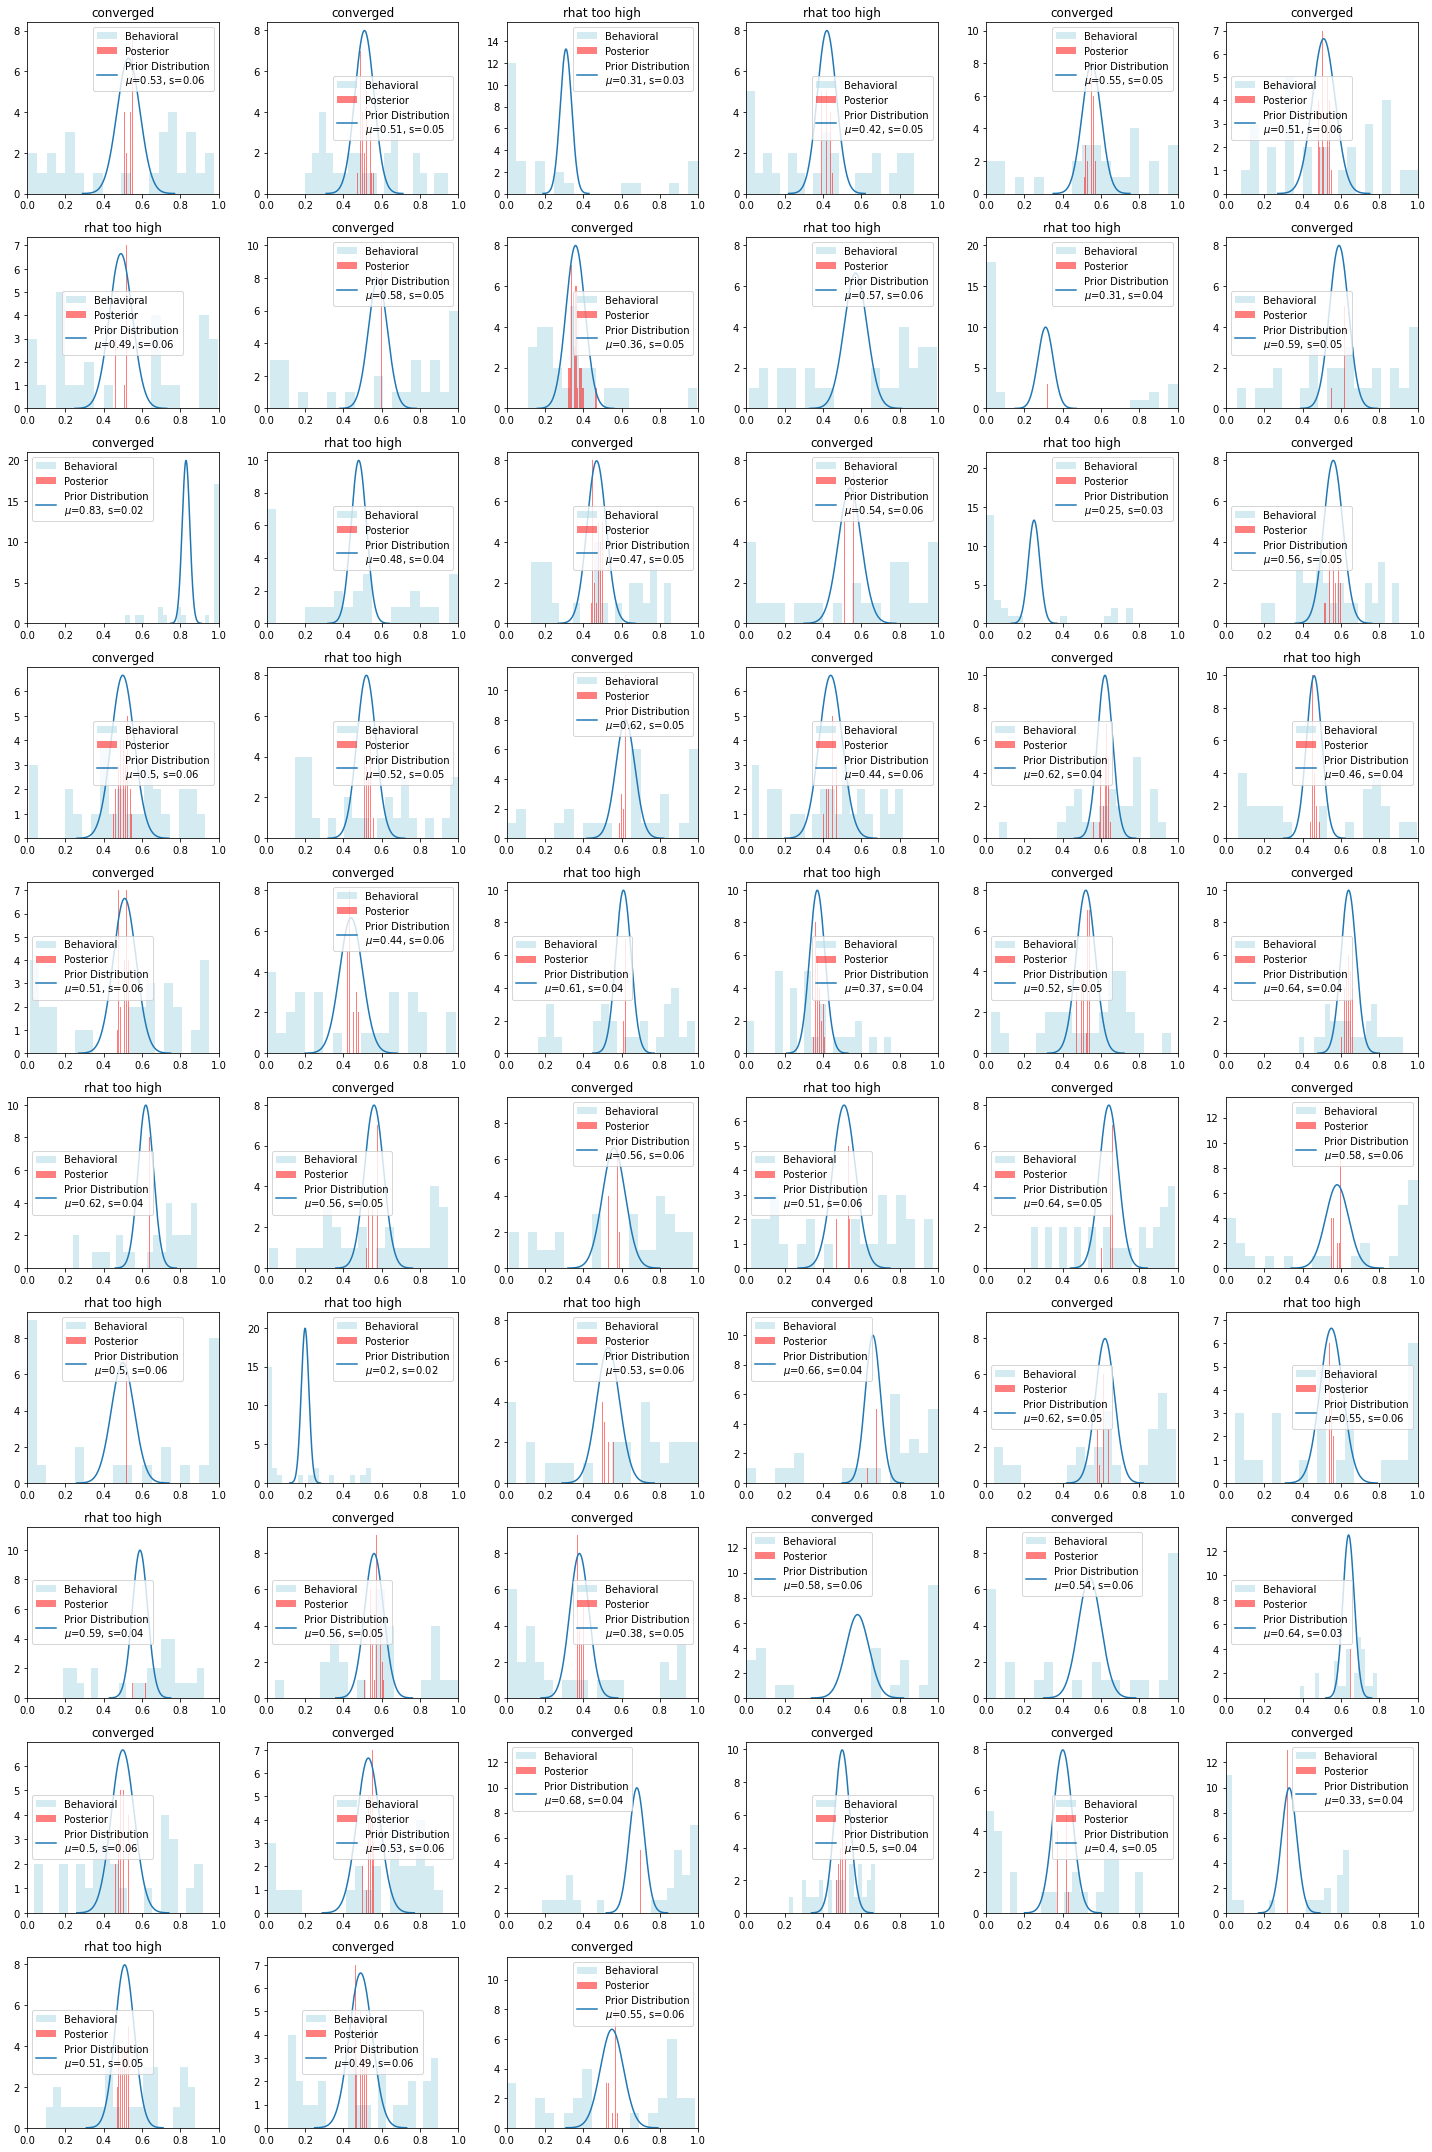

In [13]:
# Number of participants

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for idx, participant in enumerate(posterior_distributions.keys()):
    
    if participant in participants_bad_convergence: 
        title_fig = "rhat too high"
    else: 
        title_fig = "converged"
        
    
    # Parameters for the normal distribution
    mu = posterior_distributions[participant]["summary_stats"]['mean']["mu"]
    s = posterior_distributions[participant]["summary_stats"]['mean']["s"]

    # Generate x values
    x = np.linspace(mu - 4*s, mu + 4*s, 1000)

    # Generate the normal distribution (PDF)
    pdf = norm.pdf(x, mu, s)
    

    participant_emo = rating_data_emo[rating_data_emo["subject_id"] == participant].copy()

    # Normalize the 'average_rating' to a 0-1 scale
    participant_emo['normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
    participant_emo['normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)

    # Compute the average of the normalized ratings
    participant_emo['normalized_average_rating'] = participant_emo[['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)
    
    # Plotting
    axes[idx].hist(participant_emo["normalized_average_rating"], label="Behavioral", alpha=0.5, bins=20, color='lightblue')

    if participant in posterior_distributions.keys(): 
        axes[idx].hist(posterior_distributions[participant]["summary_stats"]['mean'][4:], label="Posterior", alpha=0.5, bins=20, color='red')
        axes[idx].plot(x, pdf, label=f'Prior Distribution\n$\mu$={mu}, s={s}')

    axes[idx].set_title(title_fig)
    axes[idx].set_xlim(0, 1)
    axes[idx].legend()

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

fig.tight_layout()  # Improve spacing between plots
plt.show()

## compare sigmas between emotions for each participant

In [33]:
sigmas = {}

In [34]:
for emotion in emotions: 
    with open(f'main_study_{emotion}_posterior_distributions_complete.p', 'rb') as fp:
        posterior_distributions = pickle.load(fp)
    for participant in posterior_distributions.keys(): 
        if participant not in sigmas.keys(): 
            sigmas[participant] = {}
        sigmas[participant][emotion] = posterior_distributions[participant]["summary_stats"]["mean"][2]

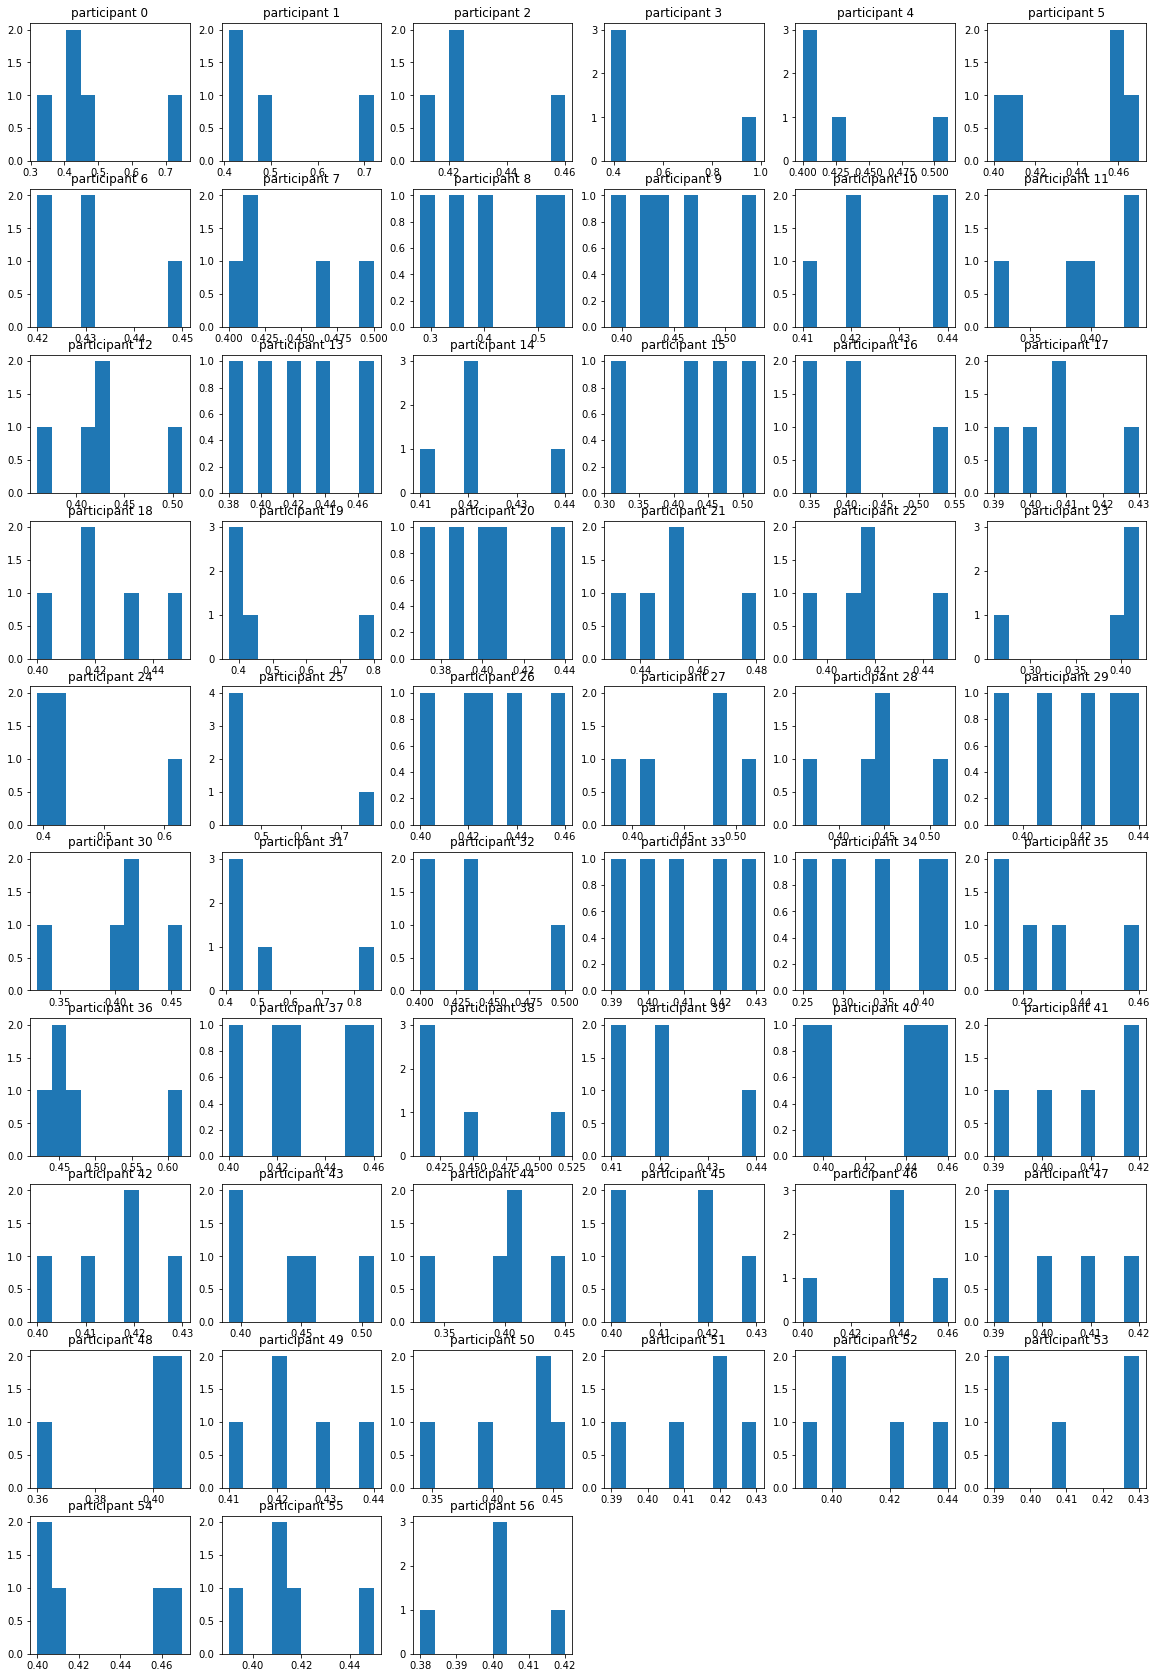

In [40]:
n_participants = len(sigmas)
# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for idx, participant in enumerate(sigmas.keys()):
    
    values = []
    for emo in sigmas[participant].keys(): 
        values.append(sigmas[participant][emo])
    axes[idx].hist(values)
    axes[idx].set_title(f"participant {idx}")
    
# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

## Lost analysis comparing short and long posteriors

## Analysis on choice

In [125]:
emotion = "sadness"

In [126]:
# get pairs from emotion discrimination phase
# load rating data from pilot study 2
all_choice_data_first_part = pd.read_csv(f"/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_choice_data/choice_data_first_part_{emotion}.csv")
all_choice_data_second_part = pd.read_csv(f"/Users/jadeserfaty/Library/Mobile Documents/com~apple~CloudDocs/code/lido/introspection_task/main_study_data/main_study_choice_data/choice_data_second_part_{emotion}.csv")
all_choice_data = pd.concat([all_choice_data_first_part, all_choice_data_second_part])

In [127]:
with open(f'main_study_{emotion}_choice_model_complete.p', 'rb') as fp:
    choice_results = pickle.load(fp)

In [128]:
print(len(choice_results))

In [129]:
# Analysis 

In [130]:
# Function to calculate accuracy
def calculate_accuracy(observed, predicted):
    predicted_choices = [1 if prob >= 0.5 else 0 for prob in predicted]
    correct_predictions = np.equal(predicted_choices, observed)
    accuracy = np.mean(correct_predictions)
    return accuracy

accuracies = []
# Calculate accuracy for each participant and print
for participant, data in choice_results.items():
    accuracy = calculate_accuracy(data["observed_choices"], data["choice_probabilities"])
#     print(f"Participant: {participant}, Accuracy: {accuracy:.2f}")
    accuracies.append(accuracy)

plt.hist(accuracies)

In [131]:
# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for idx, participant in enumerate(choice_results.keys()):
    data = choice_results[participant]
    axes[idx].scatter(data["choice_probabilities"], data["observed_choices"], alpha=0.5)
    axes[idx].set_title(f'Participant {idx}')
    axes[idx].set_xlabel('Predicted Probability')
    axes[idx].set_ylabel('Observed Choice')
    axes[idx].grid(True)
plt.title("Predicted Probabilities vs Observed Choices")

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

fig.tight_layout()  # Improve spacing between plots

plt.show()

In [132]:
# Initialize DataFrame to hold the compiled data
compiled_data = pd.DataFrame(columns=["participant", "value_diff", "consistent_choice", "observed_choice", "model_prob"])

for participant, data in choice_results.items():
    
    participant_emo = rating_data_emo[rating_data_emo["subject_id"] == participant].copy()
    video_order = participant_emo["videoID"].to_list()

    participant_choice = all_choice_data[all_choice_data["subject_id"]==participant].copy()
    participant_choice_cleaned = participant_choice.dropna(subset=['chosenVideoID', 'notChosenVideoID'])

    value_diff = []

    for index, row in participant_choice_cleaned.iterrows():
        v1 = row['chosenVideoRating']
        v2 = row['notChosenVideoRating']
        diff = abs(v1 - v2)
        value_diff.append(diff)
        
    obs_choices = data["observed_choices"]
    choice_probs = data["choice_probabilities"]
    
    # Prepare data to append
    temp_df = pd.DataFrame({
        "participant": [participant] * len(value_diff),
        "value_diff": value_diff,
        "consistent_choice": participant_choice_cleaned["consistent_choice"],
        "observed_choice": [float(x) for x in obs_choices],  # Ensure numeric
        "model_prob": [float(x) for x in choice_probs]  # Ensure numeric
    })
    
    # Append using pd.concat
    compiled_data = pd.concat([compiled_data, temp_df], ignore_index=True)

compiled_data.head()

In [133]:
# Ensure the columns are numeric
compiled_data['value_diff'] = pd.to_numeric(compiled_data['value_diff'], errors='coerce')
compiled_data['observed_choice'] = pd.to_numeric(compiled_data['observed_choice'], errors='coerce')
compiled_data['model_prob'] = pd.to_numeric(compiled_data['model_prob'], errors='coerce')

In [134]:
# Define the bin edges based on the specified percentages and margin of error
percentages = [5, 10, 15, 20, 50]
total_range = 7.0 - 1.0  # The range of the values

bin_edges = []
for percentage in percentages:
    lower_bound = ((percentage - 1) / 100) * total_range
    upper_bound = ((percentage + 1) / 100) * total_range
    bin_edges.append(lower_bound)
    bin_edges.append(upper_bound)

bin_edges = sorted(set(bin_edges))  # Remove duplicates and sort the edges

print(bin_edges)

In [135]:
# Create pairs of bin edges
bins = [(bin_edges[i], bin_edges[i+1]) for i in range(0, len(bin_edges), 2)]

# Function to categorize the value_diff into the defined bins
def categorize_value_diff(value):
    for idx, (lower, upper) in enumerate(bins):
        if lower <= value <= upper:
            return idx + 1
    return None

# Apply the function to categorize value_diff
compiled_data['value_diff_bins'] = compiled_data['value_diff'].apply(categorize_value_diff)

# Mapping bin numbers to percentages
bin_label_mapping = {1: '5%', 2: '10%', 3: '15%', 4: '20%', 5: '50%'}

# Replace numeric bin labels with percentage labels
compiled_data['value_diff_bins'] = compiled_data['value_diff_bins'].map(bin_label_mapping)

compiled_data.head()

In [136]:
# Ensure the bins are in the correct order
compiled_data['value_diff_bins'] = pd.Categorical(compiled_data['value_diff_bins'], categories=['5%', '10%', '15%', '20%', '50%'], ordered=True)

# Plotting
plt.figure(figsize=(12, 6))

# Model predictions
sns.boxplot(x='value_diff_bins', y='model_prob', data=compiled_data, color='blue', whis=[0, 100], width=.6)
sns.stripplot(x='value_diff_bins', y='model_prob', data=compiled_data, color='blue', size=4, jitter=True, alpha=0.5)

# # Observed choices
# sns.boxplot(x='value_diff_bins', y='observed_choice', data=compiled_data, color='red', whis=[0, 100], width=.6)
# sns.stripplot(x='value_diff_bins', y='observed_choice', data=compiled_data, color='red', size=4, jitter=True, alpha=0.5)

plt.xlabel('Value Difference Bins')
plt.ylabel('Probability / Choice')
plt.title(' Model Predictions Across Value Differences')
plt.grid(True)
plt.legend(['Model Predictions'])
plt.show()

here what I want to see is if the model predicts lower prob when value difference is lower and when standad deviation is higher. So I want to see for each bin if accuracy of model similar to accuracry of humans.

In [137]:
compiled_data.head()

In [138]:
# Aggregate the data by bins
aggregated_data = compiled_data.groupby('value_diff_bins').agg({
    'consistent_choice': 'mean',
    'model_prob': 'mean'
}).reset_index()

aggregated_data.head()

In [139]:
# Ensure the bins are in the correct order
aggregated_data['value_diff_bins'] = pd.Categorical(aggregated_data['value_diff_bins'], categories=['5%', '10%', '15%', '20%', '50%'], ordered=True)

# Plot the results
plt.figure(figsize=(12, 6))
sns.barplot(x='value_diff_bins', y='consistent_choice', data=aggregated_data, color='blue', alpha=0.6, label='Consistent Choice')
sns.barplot(x='value_diff_bins', y='model_prob', data=aggregated_data, color='red', alpha=0.6, label='Model Probability')

# Add a horizontal line at 50%
plt.axhline(0.5, color='green', linestyle='--', linewidth=2, label='50% Line')

plt.xlabel('Value Difference Bins')
plt.ylabel('Mean Values')
plt.title('Model Predictions vs Participant Behavior')
plt.legend()
plt.show()

# Model repulsion

## Simulation

In [140]:
# Define the rate parameter for the exponential distribution
mu = 0.5  # Mean value for the prior
s = 0.1   # Scale value for the prior
# Set your noise levels
sigma = 0.01  # Start with a small amount of internal noise # The encoding noise
sigma_ext = 0.01  # Start with a small amount of external noise # The external noise after decoding
delta = 0.05 
num_videos = 30  # Assuming you have 30 videos per emotion
# num_participants = 100  # Number of participants

In [141]:
# ATTENTION RE RUN mu and s definition otherwise they are theano form 

# Different levels of internal noise to simulate
sigma_levels = [0.05, 0.1, 0.2,0.25,0.3, 0.4,0.45, 0.5]  # Different levels of internal noise

# Placeholder for results
results = []

# Loop over different levels of internal noise
for sigma in sigma_levels:
    # Generate true emotion intensities
    true_emotion_intensities = logistic.rvs(loc=mu, scale=s, size=num_videos)

    # Simulate the encoding process with internal noise
    encoded_responses = f(true_emotion_intensities, mu, s) + np.random.normal(0, sigma, size=num_videos)
    
    # Apply the decoding process
    decoded_estimates = f_inv(encoded_responses, mu, s)

    # Add external noise to the decoded estimates
    observed_noisy_ratings = decoded_estimates + np.random.normal(0, sigma_ext, size=num_videos)
    
    # Calculate bias as the difference between observed noisy ratings and true emotion intensities
    bias = observed_noisy_ratings - true_emotion_intensities
    
    # Store results
    results.append((sigma, true_emotion_intensities, observed_noisy_ratings, bias))

In [68]:
# Plotting
plt.figure(figsize=(14, 8))

for i, (sigma, true_intensities, noisy_ratings, bias) in enumerate(results):
    plt.subplot(2, 4, i+1)
    plt.scatter(true_intensities, bias, alpha=0.2)
    plt.title(f'Internal Noise Level: {sigma}')
    plt.xlabel('True Emotion Intensity')
    plt.ylabel('Bias (Noisy Rating - True Intensity)')
    plt.axhline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()

In [69]:
# Plotting
plt.figure(figsize=(14, 8))

for i, (sigma, true_intensities, noisy_ratings, bias) in enumerate(results):
    # Sort the true intensities and corresponding biases
    sorted_indices = np.argsort(true_intensities)
    sorted_true_intensities = true_intensities[sorted_indices]
    sorted_bias = bias[sorted_indices]

    plt.subplot(2, 4, i+1)
    plt.plot(sorted_true_intensities, sorted_bias, '-o', markersize=3, alpha=0.6)  # Line plot with small markers
    plt.title(f'Internal Noise Level: {sigma}')
    plt.xlabel('True Emotion Intensity')
    plt.ylabel('Bias (Noisy Rating - True Intensity)')
    plt.axhline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()

In [70]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 8))

degree = 3  # Degree of the polynomial fit, adjust based on your data

for i, (sigma, true_intensities, noisy_ratings, bias) in enumerate(results):
    # Sorting the true_intensities and corresponding bias for plotting
    sorted_indices = np.argsort(true_intensities)
    sorted_intensities = true_intensities[sorted_indices]
    sorted_bias = bias[sorted_indices]
    
    plt.subplot(2, 4, i+1)
    plt.scatter(sorted_intensities, sorted_bias, alpha=0.2)
    
    # Fit a polynomial regression for trend line
    coeffs = np.polyfit(sorted_intensities, sorted_bias, degree)
    polynomial = np.poly1d(coeffs)
    trendline = polynomial(sorted_intensities)
    
    plt.plot(sorted_intensities, trendline, color='red')  # Trend line
    
    plt.title(f'Internal Noise Level: {sigma}')
    plt.xlabel('True Emotion Intensity')
    plt.ylabel('Bias (Noisy Rating - True Intensity)')
    plt.axhline(0, color='grey', linestyle='--')

plt.tight_layout()
plt.show()


## observed data

In [143]:
results = []
for participant, data in choice_results.items():
    
    data = posterior_distributions[participant]
    
    summary_stats = data['summary_stats']
    mu_empirical = summary_stats.loc['mu', 'mean']
    s_empirical = summary_stats.loc['s', 'mean']
    v_values = summary_stats[4:]["mean"]
    
    true_emotion_intensities = [x for x in v_values]
    
    participant_emo = rating_data_emo[rating_data_emo["subject_id"] == participant].copy()
        
    # Normalize the 'average_rating' to a 0-1 scale
    participant_emo.loc[:, 'normalized_rating_phase1'] = (participant_emo['rating_phase1'] - 1) / (7 - 1)
    participant_emo.loc[:, 'normalized_rating_phase2'] = (participant_emo['rating_phase2'] - 1) / (7 - 1)
    
    participant_emo.loc[:, 'normalized_average_rating'] = participant_emo.loc[:, ['normalized_rating_phase1', 'normalized_rating_phase2']].mean(axis=1)     
    
    observed_noisy_ratings = participant_emo["normalized_average_rating"]
    
    # Calculate bias as the difference between observed noisy ratings and true emotion intensities
    bias = observed_noisy_ratings - true_emotion_intensities
    
    results.append((true_emotion_intensities, observed_noisy_ratings, bias))


In [144]:
# Plotting
plt.figure(figsize=(14, 8))

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for i, (true_intensities, noisy_ratings, bias) in enumerate(results):
    
    axes[i].scatter(true_intensities, bias, alpha=0.2)
    axes[i].set_title(f'Participant: {i}')
    axes[i].set_xlabel('True Emotion Intensity')
    axes[i].set_ylabel('Bias (Noisy Rating - True Intensity)')
    axes[i].set_xlim([0,1])

#     plt.axhline(0, color='grey', linestyle='--')

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [145]:
# Plotting
plt.figure(figsize=(14, 8))

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for i, (true_intensities, noisy_ratings, bias) in enumerate(results):
    sorted_indices = np.argsort(true_intensities)
    true_intensities = np.array(true_intensities)
    bias = np.array(bias)
    sorted_intensities = true_intensities[sorted_indices]
    sorted_bias = bias[sorted_indices]
    
    
    axes[i].plot(sorted_intensities, sorted_bias, '-o', markersize=3, alpha=0.6)  # Line plot with small markers

    axes[i].set_title(f'Participant: {i}')
    axes[i].set_xlabel('True Emotion Intensity')
    axes[i].set_ylabel('Bias (Noisy Rating - True Intensity)')
#     axes[i].set_xlim([0,1])
  
# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

In [146]:
degree = 3  # Degree of the polynomial fit, adjust based on your data

# Plotting
plt.figure(figsize=(14, 8))

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for i, (true_intensities, noisy_ratings, bias) in enumerate(results):
    sorted_indices = np.argsort(true_intensities)
    true_intensities = np.array(true_intensities)
    bias = np.array(bias)
    sorted_intensities = true_intensities[sorted_indices]
    sorted_bias = bias[sorted_indices]
    
    axes[i].scatter(sorted_intensities, sorted_bias, alpha=0.2)
    
    # Fit a polynomial regression for trend line
    coeffs = np.polyfit(sorted_intensities, sorted_bias, degree)
    polynomial = np.poly1d(coeffs)
    trendline = polynomial(sorted_intensities)
    
    axes[i].plot(sorted_intensities, trendline, color='red')  # Trend line

    
    axes[i].set_title(f'Participant: {i}')
    axes[i].set_xlabel('True Emotion Intensity')
    axes[i].set_ylabel('Bias (Noisy Rating - True Intensity)')
#     axes[i].set_xlim([0,1])

#     plt.axhline(0, color='grey', linestyle='--')

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

plt.tight_layout()
plt.show()

# True Vs estimated values

In [149]:
# results contains (true_emotion_intensities, observed_noisy_ratings, bias) 

In [150]:
# Plotting
plt.figure(figsize=(14, 8))

# Setup the subplot grid
n_cols = 6  # you can adjust this number based on your preference
n_rows = (n_participants + n_cols - 1) // n_cols  # This ensures enough rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 30))  # Adjust figsize to fit your screen
axes = axes.flatten()  # Flatten the 2D array of axes to simplify indexing

for i, (estimated_v_values, observed_noisy_ratings, bias) in enumerate(results):
    
    axes[i].scatter(estimated_v_values, observed_noisy_ratings, alpha=0.2)
    
    
    axes[i].set_title(f'Participant: {i}')
    axes[i].set_xlabel('Estimated v values')
    axes[i].set_ylabel('observed ratings')

# Hide any unused subplots
for ax in axes[n_participants:]:
    ax.axis('off')

plt.tight_layout()
plt.show()